In [1]:
# First lets improve libraries that we are going to be used in this lab session
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from collections import Counter
import matplotlib.pyplot as plt
import csv
import pickle as pkl
import random
import pdb

PAD_IDX = 0
UNK_IDX = 1
BATCH_SIZE = 32
dic_size = 50000
label_dic = {}
label_dic["contradiction"] = 0
label_dic["entailment"] = 1
label_dic["neutral"] = 2

In [2]:
#torch.backends.cudnn.enabled = False
torch.backends.cudnn.enabled

True

In [33]:
def build_vocab():
    '''
    load pre-trained embedding: wiki-news-300d-1M.vec.zip
    '''
    token2id, id2token, embedding_matrix = load_embedding()
    
    id2token = ['<pad>', '<unk>'] + id2token
    token2id['<pad>'] = PAD_IDX
    token2id['<unk>'] = UNK_IDX
    
    pad_unk = np.append(np.zeros((1, 300), dtype=np.float64), np.random.normal(size=(1, 300)), axis=0)
    embedding_matrix = np.append(pad_unk, embedding_matrix, axis=0)
    return token2id, id2token, embedding_matrix

def load_embedding():
    token2id = {}
    id2token = []
    embedding_matrix = np.zeros((50000,300), dtype=np.float64)
    with open("wiki-news-300d-1M.vec") as embedding_file:
        i = 0
        next(embedding_file)
        for line in embedding_file:
            embedding_vec = line.rstrip('\n').split(' ')
            token2id[embedding_vec[0]] = i+2
            id2token.append(embedding_vec[0])
            embedding_matrix[i,:] = np.array(embedding_vec[1:]).astype(np.float64)
            if i == 49999:
                break
            i += 1
    return token2id, id2token, embedding_matrix

def read_data(train_file_str, val_file_str):
    '''
    read pre-tokenized data from files
    '''
    # read train data
    train_data = []
    train_label = []
    sentence_lengths = []
    with open(train_file_str) as trainfile:
        trainfile = csv.reader(trainfile, delimiter = "\t")
        next(trainfile)
        for line in trainfile:
            train_splitted = [s.split() for s in line]
            train_data.append(train_splitted[:2])
            train_label.append(label_dic[train_splitted[2][0]])
            
            # get max_sentence_length
            sentence_lengths.append(len(train_splitted[0]))
            sentence_lengths.append(len(train_splitted[1]))
    
    # read validation data
    val_data = []
    val_label = []
    with open(val_file_str) as valfile:
        valfile = csv.reader(valfile, delimiter = "\t")
        next(valfile)
        for line in valfile:
            val_splitted = [s.split() for s in line]
            val_data.append(val_splitted[:2])
            val_label.append(label_dic[val_splitted[2][0]])
    
    return train_data, train_label, val_data, val_label, int(np.percentile(np.array(sentence_lengths), 99))


In [34]:
# load data + vocab
train_data, train_label, val_data, val_label, max_sentence_length = read_data("snli_train.tsv", "snli_val.tsv")
token2id, id2token, embedding_matrix = build_vocab()

In [35]:
print ("Maximum sentence length of dataset is {}".format(max_sentence_length))
print ("Number of words in dataset is {}".format(len(id2token)))


Maximum sentence length of dataset is 30
Number of words in dataset is 50002


In [36]:
len(train_data)

100000

### Now lets build the PyTorch DataLoader as we did in previous lab

In [7]:
class SnliDataset(Dataset):
    """
    Class that represents a train/validation dataset that's readable for PyTorch
    """

    def __init__(self, data, label, token2id):
        """
        @param data_list: list of words
        @param target_list: list of labels

        """
        self.data = data
        self.label = label
        assert (len(self.data) == len(self.label))
        self.token2id = token2id

    def __len__(self):
        return len(self.data)

    def __getitem__(self, key):
        #print(key)
        #print("a")
        #print(self.data[key][:max_sentence_length])
        #print("b")
        token_idx1 = [self.token2id[c] if c in self.token2id.keys() else UNK_IDX  for c in self.data[key][0][:max_sentence_length]]
        token_idx2 = [self.token2id[c] if c in self.token2id.keys() else UNK_IDX  for c in self.data[key][1][:max_sentence_length]]
        token_idx = [token_idx1, token_idx2]
        label = self.label[key]
        return [token_idx, [len(idxs) for idxs in token_idx], label]

def Snli_collate_func(batch):
    """
    Customized function for DataLoader that dynamically pads the batch so that all
    data have the same length
    """
    data_list1 = []
    data_list2 = []
    label_list = []
    length_list1 = []
    length_list2 = []

    for datum in batch:
        label_list.append(datum[2])
        length_list1.append(datum[1][0])
        length_list2.append(datum[1][1])
    
    # padding
    for datum in batch:
        padded_vec1 = np.pad(np.array(datum[0][0]),
                                pad_width=((0,max_sentence_length-datum[1][0])),
                                mode="constant", constant_values=0)
        data_list1.append(padded_vec1)
        
        padded_vec2 = np.pad(np.array(datum[0][1]),
                                pad_width=((0,max_sentence_length-datum[1][1])),
                                mode="constant", constant_values=0)
        data_list2.append(padded_vec2)
        
    #ind_dec_order = np.argsort(length_list)[::-1]
    #data_list = np.array(data_list)[ind_dec_order]
    #length_list = np.array(length_list)[ind_dec_order]
    #label_list = np.array(label_list)[ind_dec_order]
    return [torch.from_numpy(np.array(data_list1)), torch.from_numpy(np.array(data_list2)), torch.LongTensor(length_list1),torch.LongTensor(length_list2), torch.LongTensor(label_list)]


In [8]:
# Build train, valid and test dataloaders

snli_train_dataset = SnliDataset(train_data, train_label, token2id)
snli_train_loader = torch.utils.data.DataLoader(dataset=snli_train_dataset,
                                           batch_size=BATCH_SIZE,
                                           collate_fn=Snli_collate_func,
                                           shuffle=True)

snli_val_dataset = SnliDataset(val_data, val_label,token2id)
snli_val_loader = torch.utils.data.DataLoader(dataset=snli_val_dataset,
                                           batch_size=BATCH_SIZE,
                                           collate_fn=Snli_collate_func,
                                           shuffle=True)

In [9]:
snli_train_dataset[0]

[[[106,
   802,
   1830,
   8,
   9,
   6265,
   7167,
   4388,
   17,
   9,
   12229,
   5335,
   9,
   563,
   6,
   358,
   4],
  [106, 802, 1830, 2255, 3, 13985, 94, 3, 358, 4]],
 [17, 10],
 2]

## Implement CNN model

In [10]:
torch.cuda.is_available()

True

In [11]:
device = torch.device("cuda")

In [12]:
print(device)

cuda


In [13]:
class CNN(nn.Module):
    def __init__(self, emb_size, hidden_size, num_classes, dic_size, embed, kernel_size=3, padding_size=1):

        super(CNN, self).__init__()

        self.hidden_size = hidden_size
        #self.embedding = nn.Embedding(dic_size, emb_size, padding_idx=PAD_IDX, _weight=weight)
        mask = np.zeros((embed.shape[0],1))
        mask[0] = 1
        mask[1] = 1
        mask = torch.from_numpy(mask).float()
        
        self.mask_embedding = nn.Embedding.from_pretrained(mask, freeze = True)
        self.dynamic_embedding = nn.Embedding.from_pretrained(embed.float(), freeze = False)
        #self.frozen_embedding = nn.Embedding.from_pretrained(embed.clone().detach(), freeze = True)
        
        self.conv1 = nn.Conv1d(emb_size, hidden_size, kernel_size=kernel_size, padding=padding_size)
        self.conv2 = nn.Conv1d(hidden_size, hidden_size, kernel_size=kernel_size, padding=padding_size)
        
        self.linear1 = nn.Linear(hidden_size*2, hidden_size*2)
        self.linear2 = nn.Linear(hidden_size*2, num_classes)
        

    def forward(self, x, lengths):
        batch_size, seq_len = x[0].size()
        
        vec_representations = []
        
        for idx, data in enumerate(x):
            # sort
            #_, sorted_idx = torch.sort(lengths[idx],descending=True)
            #_, unsorted_idx = torch.sort(sorted_idx)
            
            
            #embed = self.mask_embedding(data[sorted_idx])*self.dynamic_embedding(data[sorted_idx]).float()+self.mask_embedding(data[sorted_idx])*self.frozen_embedding(data[sorted_idx]).float()
            e = self.dynamic_embedding(data)
            #print(e)
            m = self.mask_embedding(data)
            embed = m*e+(1-m)*e.clone().detach()
            #print(embed)
            
            # 2 layers of convolutionary layer with relu
            hidden = self.conv1(embed.transpose(1,2)).transpose(1,2)
            hidden = F.relu(hidden.contiguous().view(-1, hidden.size(-1))).view(batch_size, seq_len, hidden.size(-1))
            
            hidden = self.conv2(hidden.transpose(1,2)).transpose(1,2)
            hidden = F.relu(hidden.contiguous().view(-1, hidden.size(-1))).view(batch_size, seq_len, hidden.size(-1))
            #print(hidden)
            # max-pooling over seq
            hidden = torch.max(hidden, 1)[0]
            
            # add to representation with original order
            #print(hidden)
            vec_representations.append(hidden)
        
        concat_representations = torch.cat(vec_representations, 1)
        logits = self.linear1(concat_representations)
        logits = F.relu(logits)
        logits = self.linear2(logits)
        return logits

In [14]:
def test_model(loader, model):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    correct = 0
    total = 0
    model.eval()
    for data1, data2, lengths1, lengths2, labels in loader:
        data1 = data1.to(device)
        data2 = data2.to(device)
        lengths1 = lengths1.to(device)
        lengths2 = lengths2.to(device)
        labels = labels.to(device)
        
        data_batch, lengths_batch, label_batch = [data1, data2], [lengths1, lengths2], labels
        outputs = F.softmax(model(data_batch, lengths_batch), dim=1)
        predicted = outputs.max(1, keepdim=True)[1]
        #print(predicted)

        total += labels.size(0)
        correct += predicted.eq(labels.view_as(predicted)).sum().item()
    return (100 * correct / total)

def run_model(change_param, hidden_size=200, num_classes=3, dic_size=len(id2token), embed=torch.from_numpy(embedding_matrix),kernel_size=3, padding_size=1):
    learning_rate = 3e-4
    num_epochs = 10 # number epoch to train
    
    model = CNN(emb_size=300, hidden_size=hidden_size, num_classes=num_classes, dic_size=dic_size, embed=embed, kernel_size=kernel_size, padding_size=padding_size)
    model.to(device)
    
    # Criterion and Optimizer
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    # Train the model
    total_step = len(snli_train_loader)
    val_accuracy = []
    train_accuracy = []
    epoch_list = []
    correct = 0
    total = 0
    max_val = 0
    for epoch in range(num_epochs):
        #running_loss = 0
        correct = 0
        total = 0
        for i, (data1, data2, lengths1, lengths2, labels) in enumerate(snli_train_loader):
            
            data1 = data1.to(device)
            data2 = data2.to(device)
            lengths1 = lengths1.to(device)
            lengths2 = lengths2.to(device)
            labels = labels.to(device)
            
            model.train()
            
            optimizer.zero_grad()
            # Forward pass 1
            outputs = model([data1, data2], [lengths1, lengths2])
            
            
            #print(outputs)
            loss = criterion(outputs, labels)

            # Backward and optimize 1
            #emb = model.embedding.weight.clone().detach()
            #print(model.dynamic_embedding.weight)
            #print(model.frozen_embedding.weight)
            #print(model.mask_embedding.weight)
            loss.backward()
            optimizer.step()
            #print("after autograd")
            #print(model.dynamic_embedding.weight)
            #print(model.frozen_embedding.weight)
            #print(model.mask_embedding.weight)
            #model.embedding.weight.data = mask * model.embedding.weight + (1-mask) * emb
            
            #running_loss += loss.item()
            # calculate train accuracy
            predicted = (F.softmax(outputs, dim=1)).max(1, keepdim=True)[1]

            total += labels.size(0)
            correct += predicted.eq(labels.view_as(predicted)).sum().item()

            # validate every 100 iterations
            if i > 0 and i % 500 == 0:
                # validate
                val_acc = test_model(snli_val_loader, model)
                #train_loss.append(running_loss/500)
                train_accuracy.append(100 * correct / total)
                val_accuracy.append(val_acc)
                epoch_list.append(str((epoch+1, i+1)))
                
                if val_acc > max_val:
                    # if kernel size change
                    if change_param == "kernel_size":
                        torch.save(model.state_dict(), "cnnbest"+str(kernel_size)+".pt")
                    elif change_param == "hidden_size":
                        torch.save(model.state_dict(), "cnnbesthidden"+str(hidden_size)+".pt")
                    else:
                        raise("param error")
                
                #print('Epoch: [{}/{}], Step: [{}/{}], trainning loss: {}, Validation Acc: {}'.format( 
                       #epoch+1, num_epochs, i+1, len(snli_train_loader), running_loss/500,val_acc))
                with open('output-gpu.txt', 'a') as f:
                    f.write('Epoch: [{}/{}], Step: [{}/{}], trainning Acc: {}, Validation Acc: {} \n'.format( 
                       epoch+1, num_epochs, i+1, len(snli_train_loader), 100 * correct / total,val_acc))
                
                correct = 0
                total = 0
    
    val_acc_i = test_model(snli_val_loader, model)
    max_val = max(val_accuracy)
    if val_acc_i > max_val:
        if change_param == "kernel_size":
            torch.save(model.state_dict(), "cnnbest"+str(kernel_size)+".pt")
        elif change_param == "hidden_size":
            torch.save(model.state_dict(), "cnnbesthidden"+str(hidden_size)+".pt")
        else:
            raise("param error")
    
    return max(max_val, val_acc_i), train_accuracy, val_accuracy, epoch_list

# learning_rate = 3e-4
# num_epochs = 5 # number epoch to train

# # Criterion and Optimizer
# criterion = torch.nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# # Train the model
# total_step = len(snli_train_loader)

# for epoch in range(num_epochs):
#     for i, (data1, data2, lengths1, lengths2, labels) in enumerate(snli_train_loader):
#         model.train()
#         optimizer.zero_grad()
#         # Forward pass 1
#         outputs = model([data1, data2], [lengths1, lengths2])
#         #print(outputs)
#         loss = criterion(outputs, labels)

#         # Backward and optimize 1
#         #emb = model.embedding.weight.clone().detach()
#         loss.backward()
#         optimizer.step()
#         #model.embedding.weight.data = mask * model.embedding.weight + (1-mask) * emb
        
#         # validate every 100 iterations
#         if i > 0 and i % 100 == 0:
#             # validate
#             val_acc = test_model(snli_val_loader, model)
#             print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}'.format(
#                        epoch+1, num_epochs, i+1, len(snli_train_loader), val_acc))


#### tune kernal size

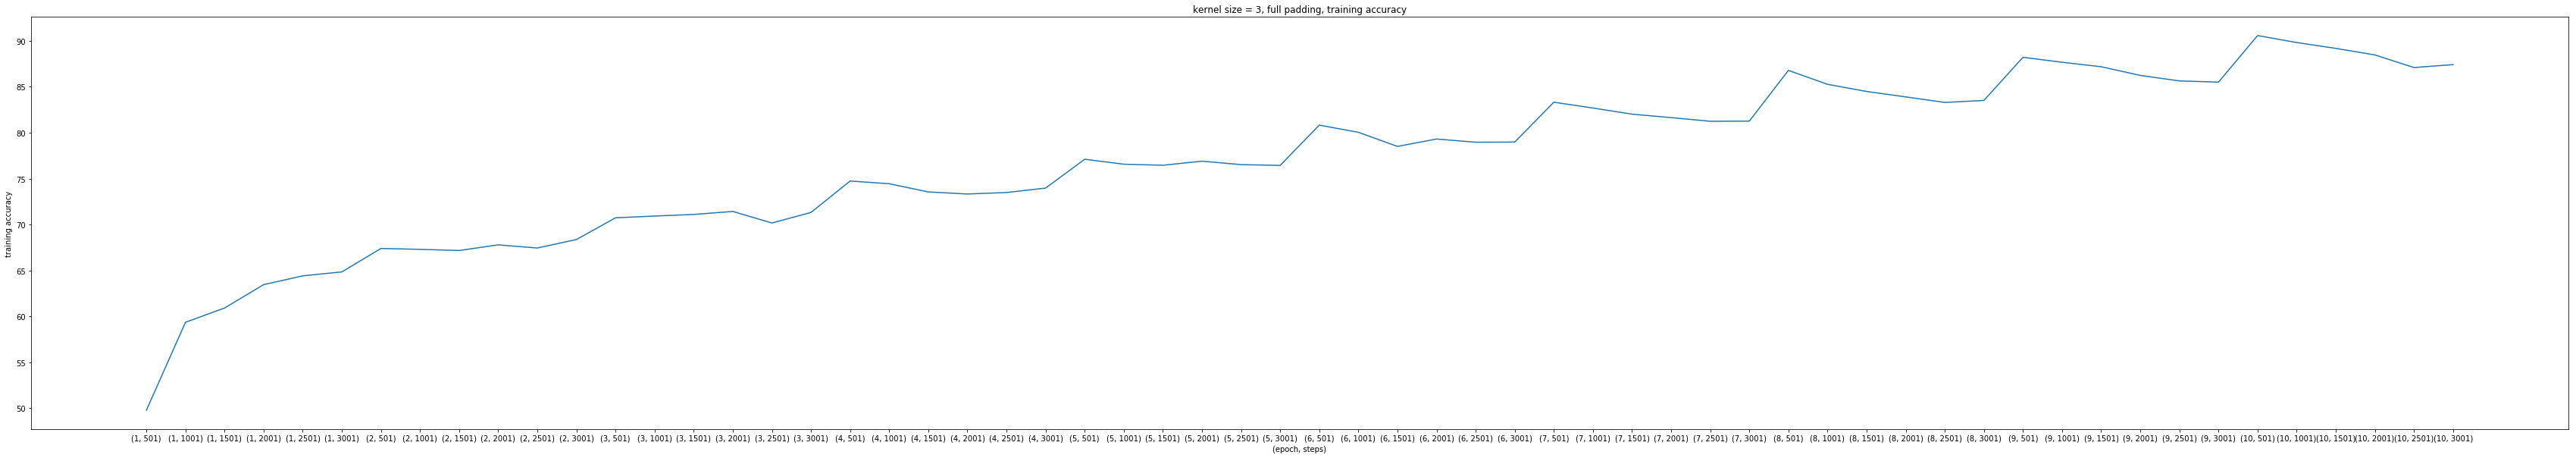

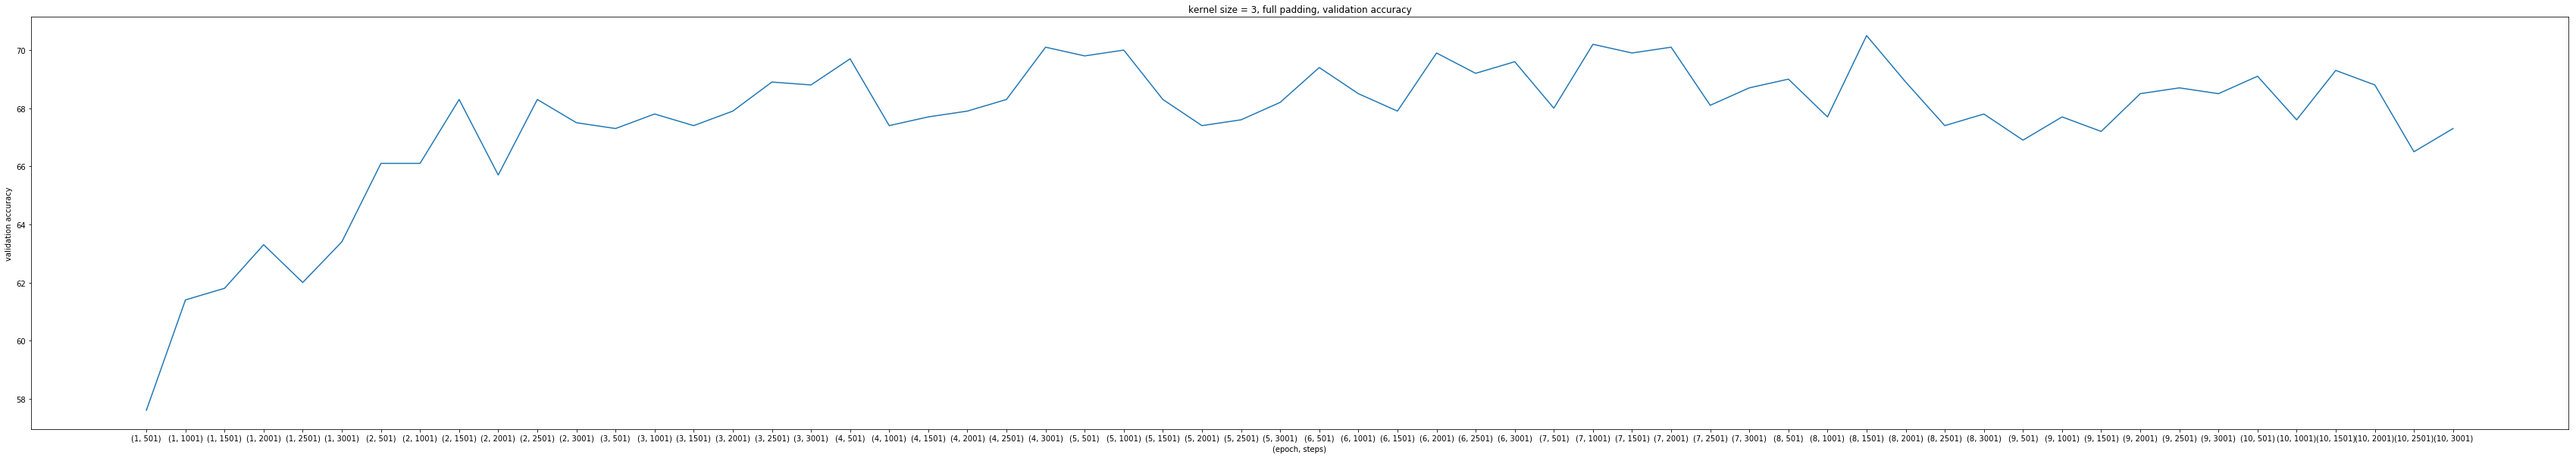

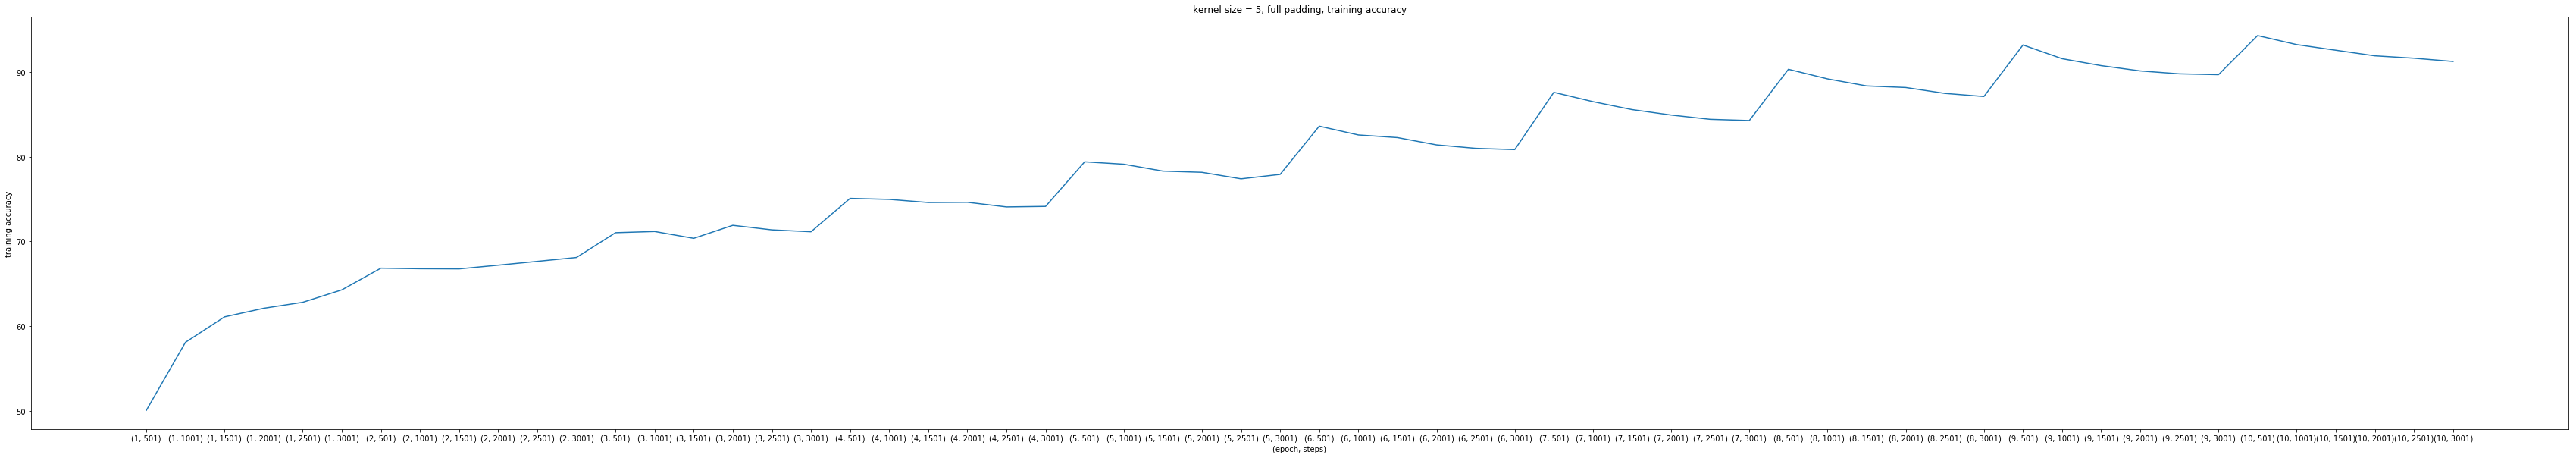

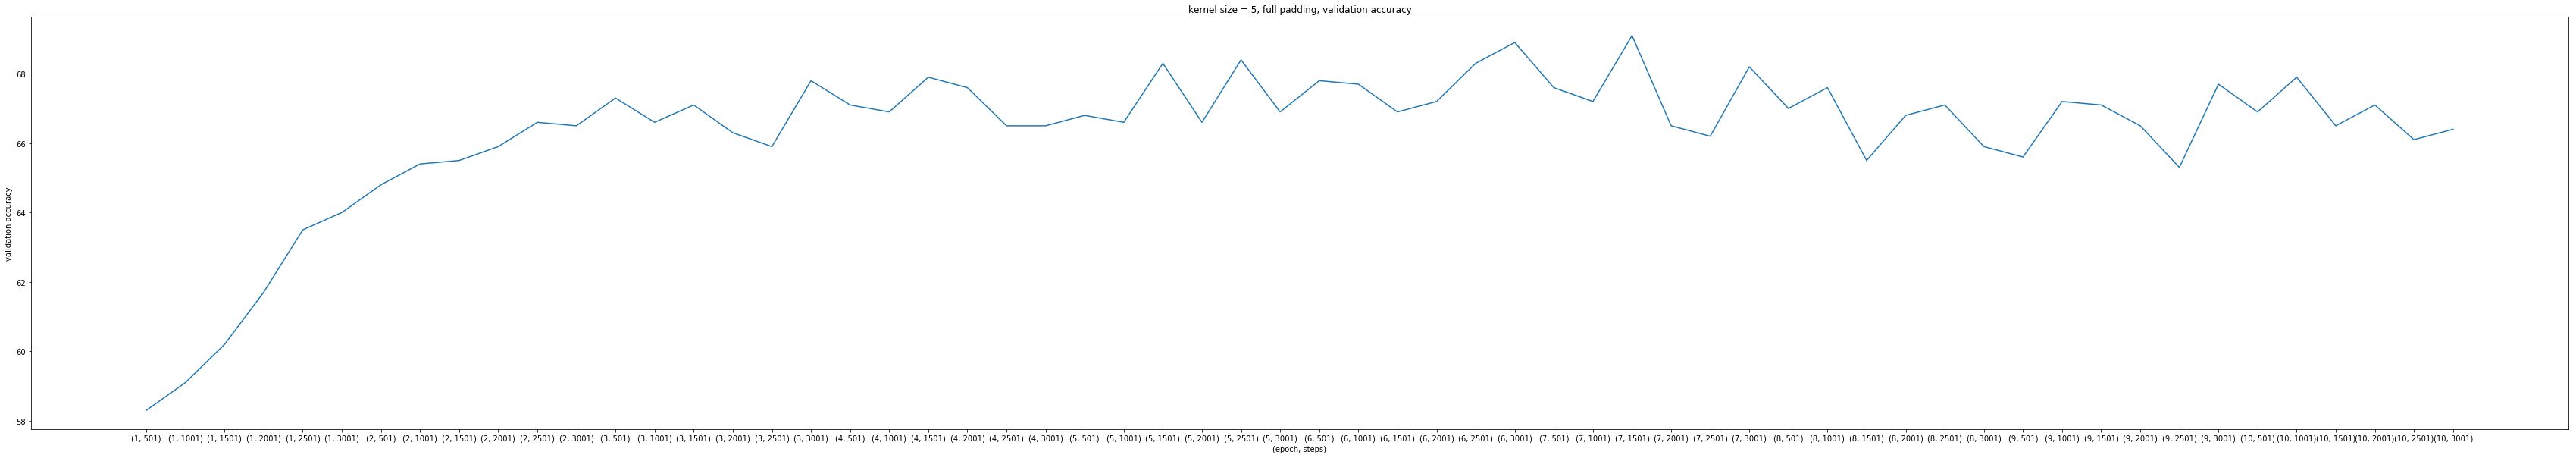

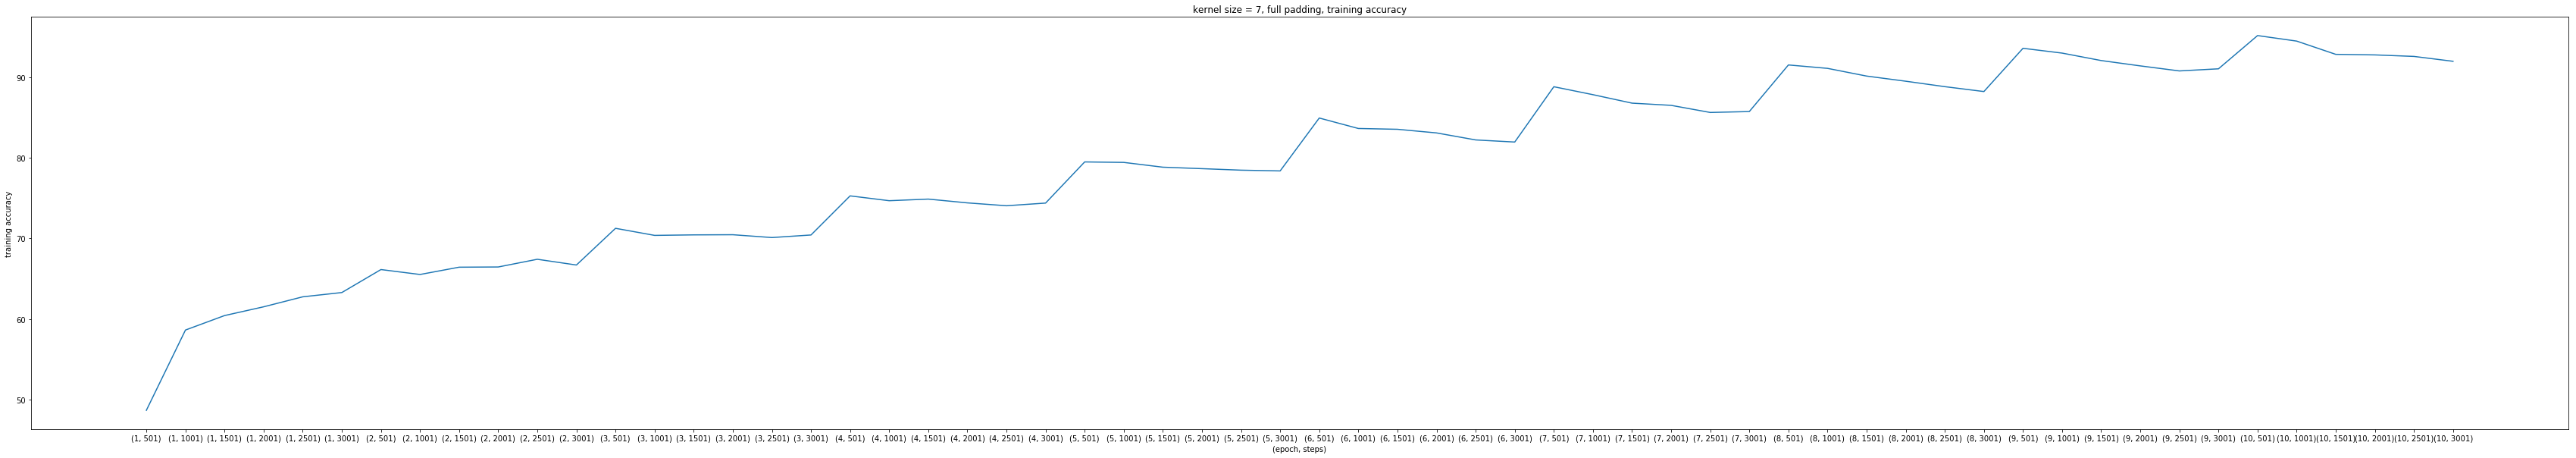

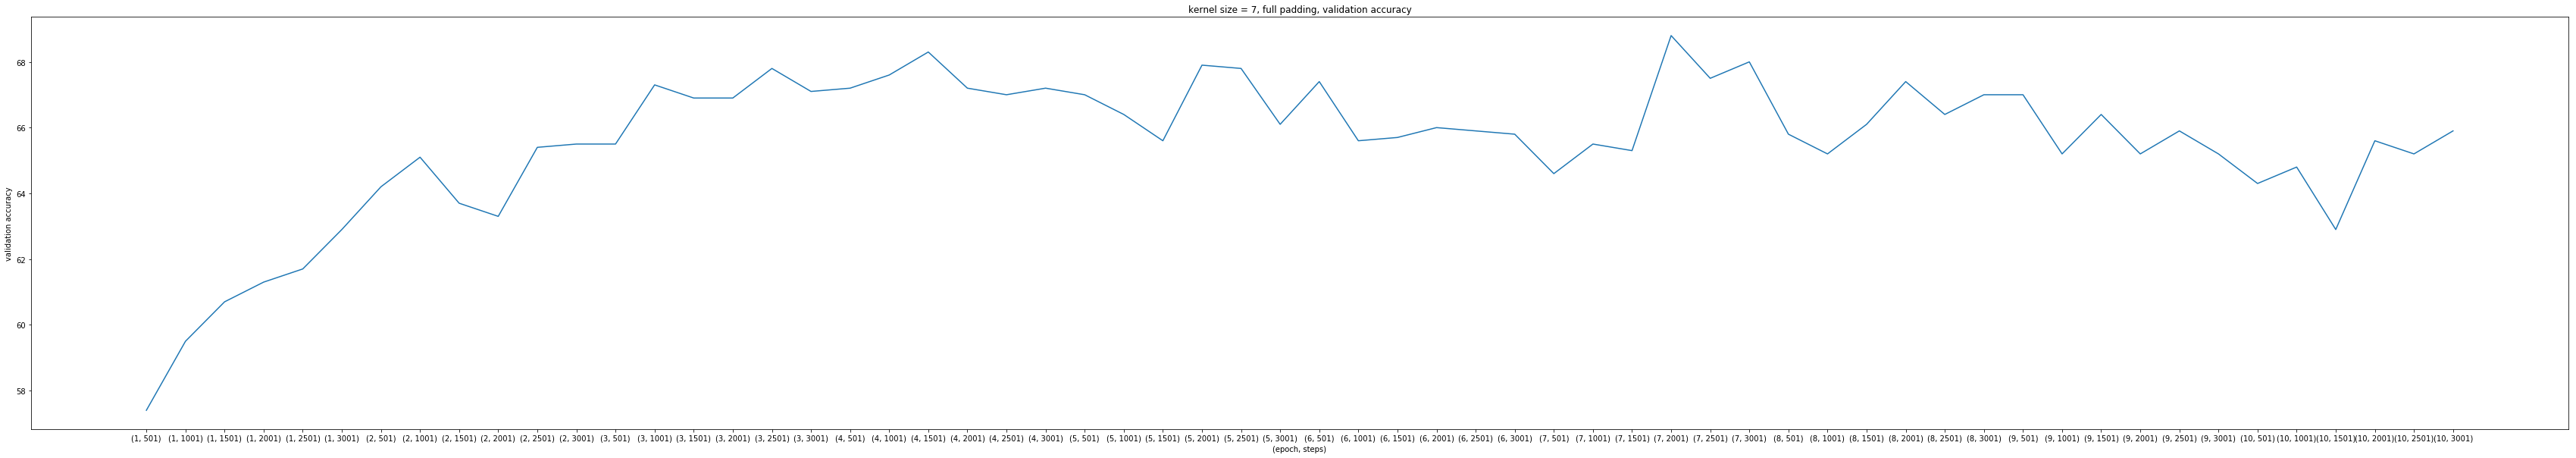

In [15]:
for kernel_size in [3,5,7]:
    with open('output-gpu.txt', 'a') as f:
        f.write("CNN kernel size {} \n".format(kernel_size))
    max_val, train_acc, val_accuracy, epoch_list = run_model(change_param = "kernel_size", kernel_size=kernel_size, padding_size=kernel_size//2)
    
    #print ("Val Acc {}".format(max_val))
    
    with open('output-gpu.txt', 'a') as f:
        f.write("Val Acc {} \n".format(max_val))

    plt.figure(figsize=(60,10))
    plt.plot(range(len(epoch_list)), train_acc)
    plt.xticks(range(len(epoch_list)), epoch_list)
    plt.xlabel("(epoch, steps)")
    plt.ylabel("training accuracy")
    plt.title("kernel size = "+str( kernel_size)+ ", full padding, training accuracy")
    plt.savefig("train_accuracy-gpu,kenel"+str(kernel_size)+".png")
    plt.show()

    plt.figure(figsize=(60,10))
    plt.plot(range(len(epoch_list)), val_accuracy)
    plt.xticks(range(len(epoch_list)), epoch_list)
    plt.xlabel("(epoch, steps)")
    plt.ylabel("validation accuracy")
    plt.title("kernel size = "+str( kernel_size)+ ", full padding, validation accuracy")
    plt.savefig("val_acc-gpu,kenel"+str(kernel_size)+".png")
    plt.show()

#### tune hidden size

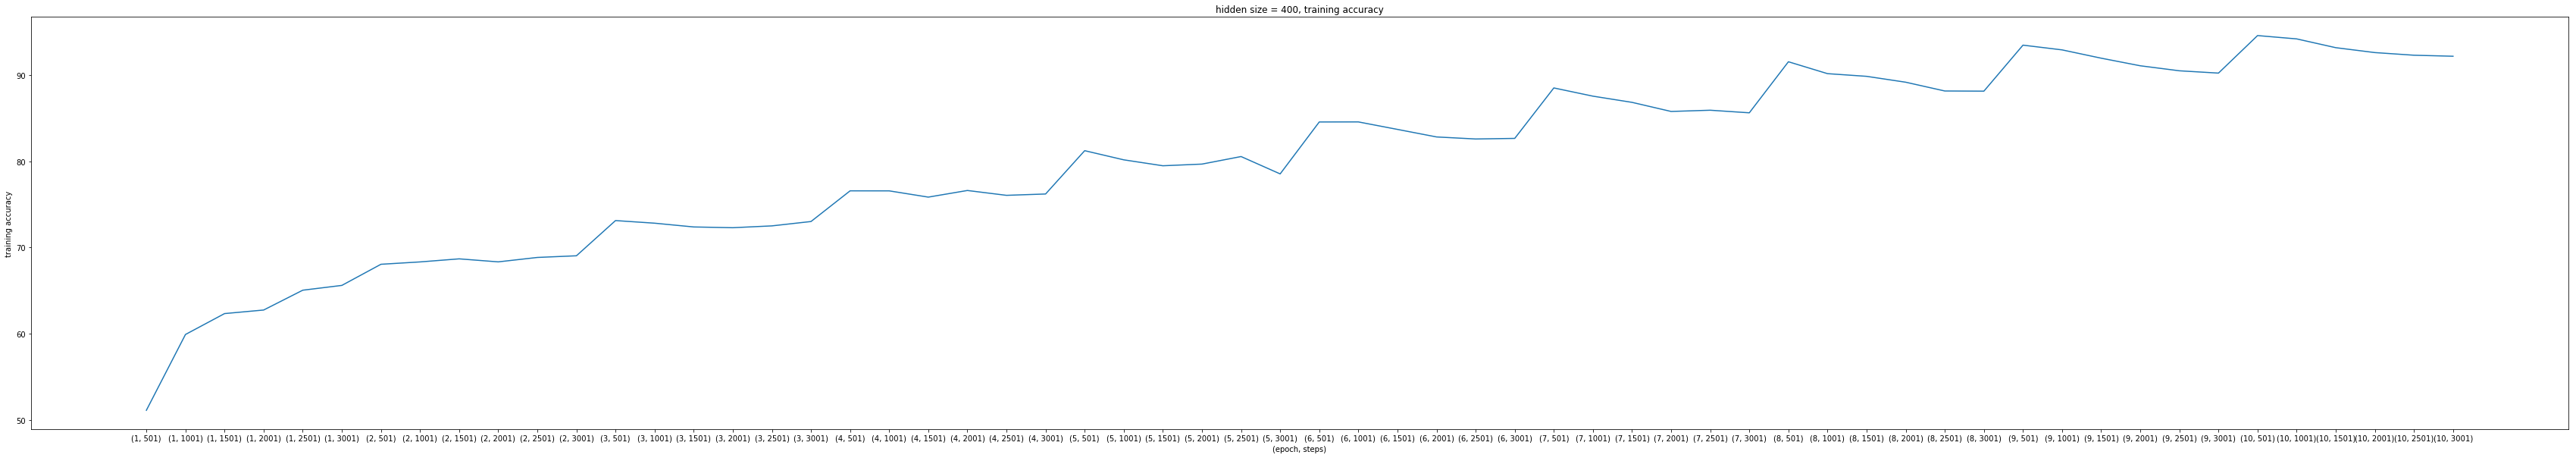

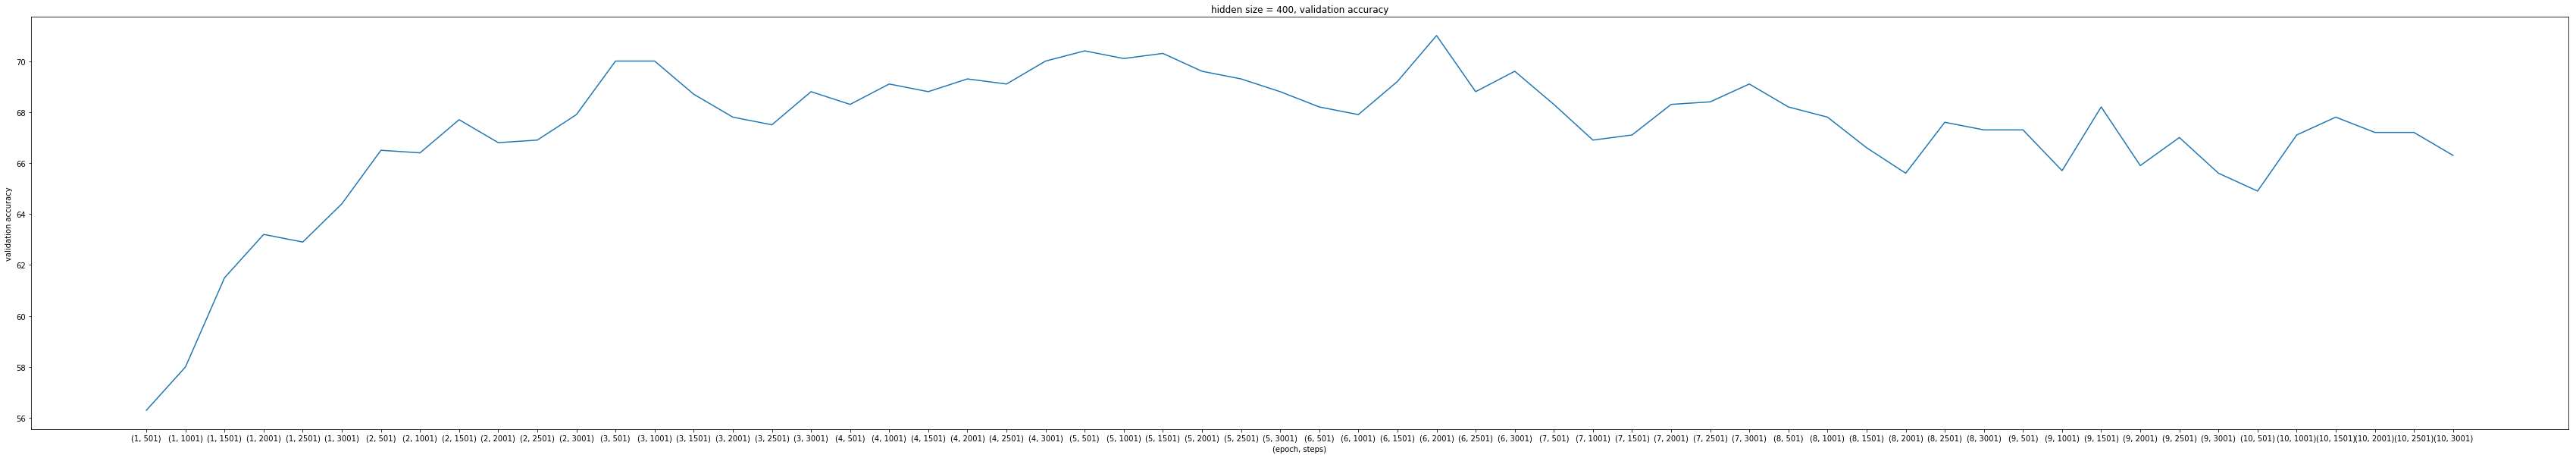

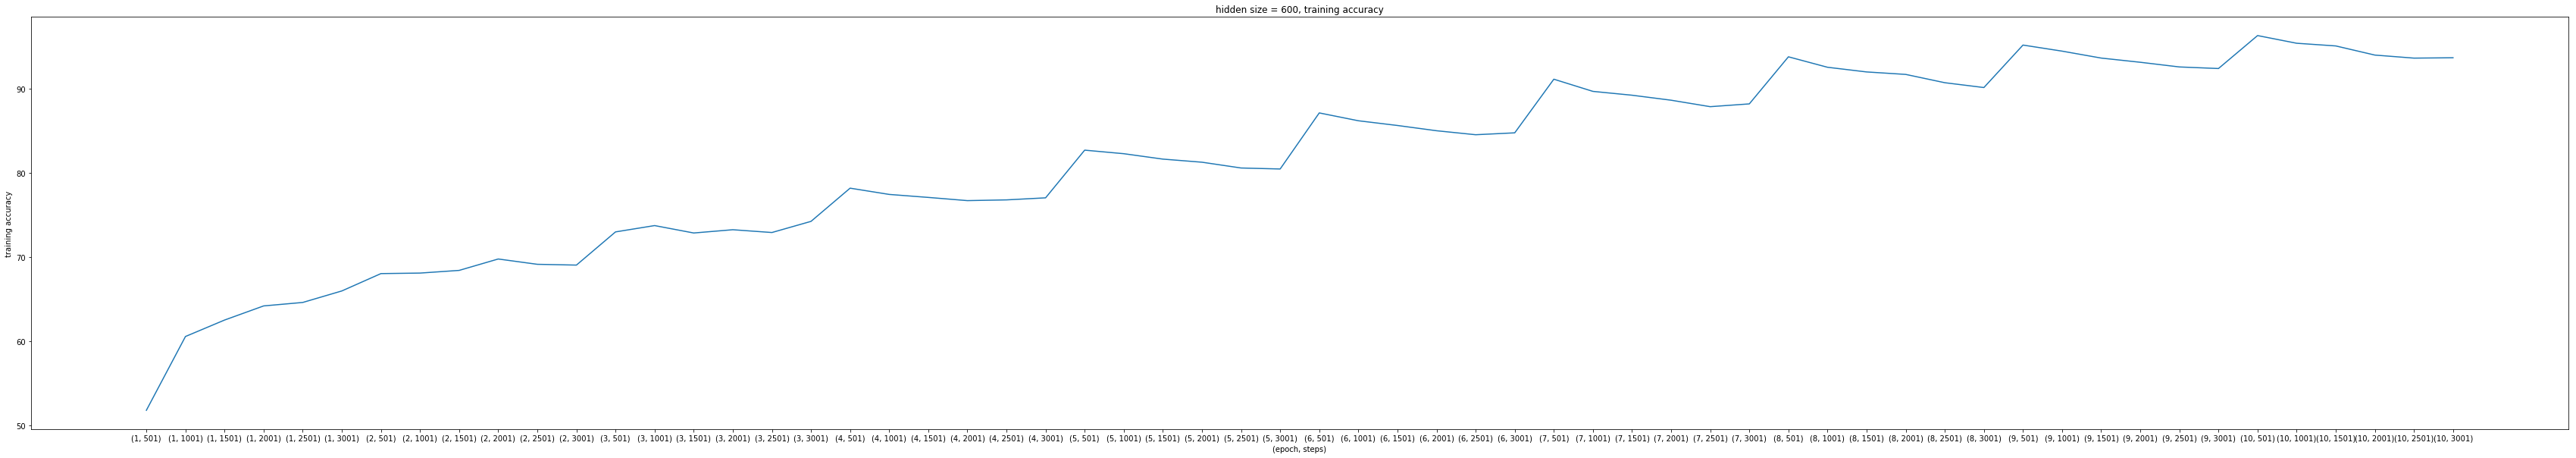

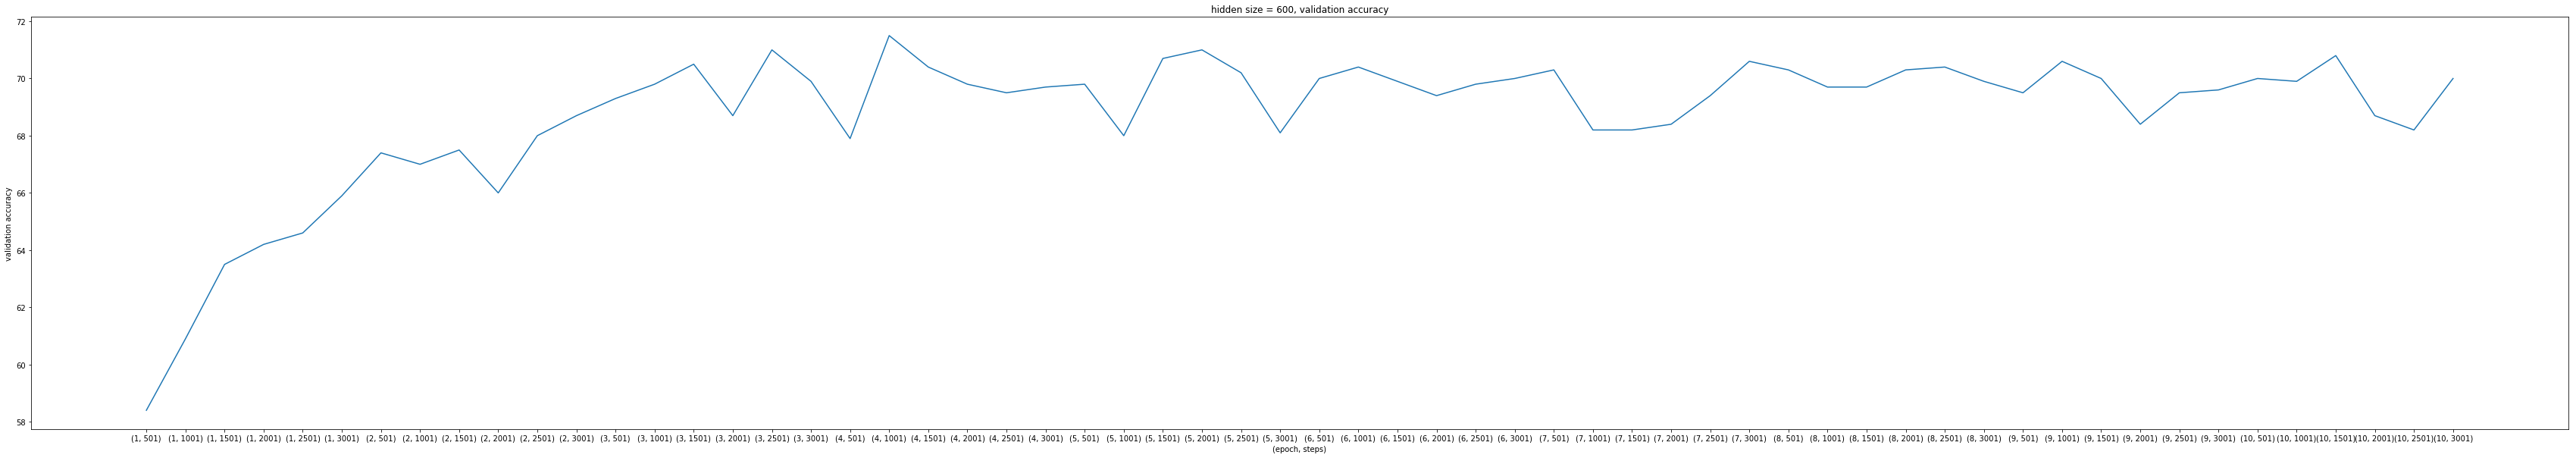

In [16]:
for hidden_size in [400,600]:
    with open('output-gpu.txt', 'a') as f:
        f.write("CNN hidden size {} \n".format(hidden_size))
    max_val, train_acc, val_accuracy, epoch_list = run_model(change_param = "hidden_size",hidden_size = hidden_size)
    
    #print ("Val Acc {}".format(max_val))
    
    with open('output-gpu.txt', 'a') as f:
        f.write("Val Acc {} \n".format(max_val))

    plt.figure(figsize=(60,10))
    plt.plot(range(len(epoch_list)), train_acc)
    plt.xticks(range(len(epoch_list)), epoch_list)
    plt.xlabel("(epoch, steps)")
    plt.ylabel("training accuracy")
    plt.title("hidden size = "+str( hidden_size)+ ", training accuracy")
    plt.savefig("train_accuracy-gpu,hidden"+str(hidden_size)+"cnn.png")
    plt.show()

    plt.figure(figsize=(60,10))
    plt.plot(range(len(epoch_list)), val_accuracy)
    plt.xticks(range(len(epoch_list)), epoch_list)
    plt.xlabel("(epoch, steps)")
    plt.ylabel("validation accuracy")
    plt.title("hidden size = "+str( hidden_size)+ ", validation accuracy")
    plt.savefig("val_acc-gpu,hidden"+str(hidden_size)+"cnn.png")
    plt.show()

## Implement RNN model

In [17]:

snli_train_dataset = SnliDataset(train_data, train_label, token2id)
snli_train_loader_rnn = torch.utils.data.DataLoader(dataset=snli_train_dataset,
                                           batch_size=BATCH_SIZE,
                                           collate_fn=Snli_collate_func,
                                           shuffle=True)

snli_val_dataset = SnliDataset(val_data, val_label,token2id)
snli_val_loader_rnn = torch.utils.data.DataLoader(dataset=snli_val_dataset,
                                           batch_size=BATCH_SIZE,
                                           collate_fn=Snli_collate_func,
                                           shuffle=True)

In [18]:
class RNN_gru(nn.Module):
    def __init__(self, emb_size, hidden_size, num_classes, dic_size, embed):
        # RNN Accepts the following hyperparams:
        # emb_size: Embedding Size
        # hidden_size: Hidden Size of layer in RNN
        # num_layers: number of layers in RNN
        # num_classes: number of output classes
        # vocab_size: vocabulary size
        super(RNN_gru, self).__init__()

        self.hidden_size = hidden_size
        
        mask = np.zeros((embed.shape[0],1))
        mask[0] = 1
        mask[1] = 1
        mask = torch.from_numpy(mask).float()
        
        self.mask_embedding = nn.Embedding.from_pretrained(mask, freeze = True)
        self.dynamic_embedding = nn.Embedding.from_pretrained(embed, freeze = False)
        
        self.gru = nn.GRU(emb_size, hidden_size, 1, batch_first=True, bidirectional = True)
        self.linear1 = nn.Linear(hidden_size*2, hidden_size*2)
        self.linear2 = nn.Linear(hidden_size*2, num_classes)

    def init_hidden(self, batch_size):
        # Function initializes the activation of recurrent neural net at timestep 0
        # Needs to be in format (num_layers, batch_size, hidden_size)
        hidden = torch.randn(2, batch_size, self.hidden_size)

        return hidden

    def forward(self, x, lengths): 
        batch_size, seq_len = x[0].size()
        vec_representations = []
        for idx, data in enumerate(x):
            # sort
            _, sorted_idx = torch.sort(lengths[idx],descending=True)
            _, unsorted_idx = torch.sort(sorted_idx)
            
            #print(data)
            #print(sorted_idx)
            
            #embed = self.dynamic_embedding(data[sorted_idx]).float()+self.frozen_embedding(data[sorted_idx]).float()
            
            e = self.dynamic_embedding(data[sorted_idx]).float()
            #print(e)
            embed = self.mask_embedding(data[sorted_idx])*e+(1-self.mask_embedding(data[sorted_idx]))*e.clone().detach()

            self.hidden = self.init_hidden(batch_size).to(device)

            # pack padded sequence
            #print(lengths[idx][sorted_idx])
            embed = torch.nn.utils.rnn.pack_padded_sequence(embed, lengths[idx].cpu()[sorted_idx].numpy(), batch_first=True)
            
            # fprop though RNN
            rnn_out, self.hidden = self.gru(embed, self.hidden)
            # undo packing
            rnn_out, _ = torch.nn.utils.rnn.pad_packed_sequence(rnn_out, batch_first=True)
            
            # add to representation with original order
            #print(hidden)
            #hidden = torch.cat([self.hidden[0,:,:],self.hidden[1,:,:]], dim=1)
            hidden = torch.sum(self.hidden, dim = 0)
            #print(hidden.shape)
            
            vec_representations.append(hidden[unsorted_idx])
            
        
        concat_representations = torch.cat(vec_representations, 1)
        logits = self.linear1(concat_representations)
        logits = F.relu(logits)
        logits = self.linear2(logits)
        return logits

In [19]:
# def test_model(loader, model):
#     """
#     Help function that tests the model's performance on a dataset
#     @param: loader - data loader for the dataset to test against
#     """
#     correct = 0
#     total = 0
#     model.eval()
#     for data1, data2, lengths1, lengths2, labels in loader:
#         data_batch, lengths_batch, label_batch = [data1, data2], [lengths1, lengths2], labels
#         outputs = F.softmax(model(data_batch, lengths_batch), dim=1)
#         predicted = outputs.max(1, keepdim=True)[1]
#         #print(predicted)

#         total += labels.size(0)
#         correct += predicted.eq(labels.view_as(predicted)).sum().item()
#     return (100 * correct / total)


# model = RNN_gru(emb_size=300, hidden_size=200, num_classes=3, dic_size=len(id2token), embed=torch.from_numpy(embedding_matrix))

# learning_rate = 3e-4
# num_epochs = 8 # number epoch to train

# # Criterion and Optimizer
# criterion = torch.nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# # Train the model
# total_step = len(snli_train_loader_rnn)

# for epoch in range(num_epochs):
#     for i, (data1, data2, lengths1, lengths2, labels) in enumerate(snli_train_loader_rnn):
#         model.train()
#         optimizer.zero_grad()
#         # Forward pass
#         outputs = model([data1, data2], [lengths1, lengths2])
#         loss = criterion(outputs, labels)

#         # Backward and optimize
#         loss.backward()
#         optimizer.step()
#         # validate every 100 iterations
#         if i > 0 and i % 100 == 0:
#             # validate
#             val_acc = test_model(snli_val_loader_rnn, model)
#             print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}'.format(
#                        epoch+1, num_epochs, i+1, len(snli_train_loader_rnn), val_acc))

def test_model(loader, model):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    correct = 0
    total = 0
    model.eval()
    for data1, data2, lengths1, lengths2, labels in loader:
        data1 = data1.to(device)
        data2 = data2.to(device)
        lengths1 = lengths1.to(device)
        lengths2 = lengths2.to(device)
        labels = labels.to(device)
        
        data_batch, lengths_batch, label_batch = [data1, data2], [lengths1, lengths2], labels
        outputs = F.softmax(model(data_batch, lengths_batch), dim=1)
        predicted = outputs.max(1, keepdim=True)[1]
        #print(predicted)

        total += labels.size(0)
        correct += predicted.eq(labels.view_as(predicted)).sum().item()
    return (100 * correct / total)

def run_model(hidden_size=200, num_classes=3, dic_size=len(id2token), embed=torch.from_numpy(embedding_matrix)):
    learning_rate = 3e-4
    num_epochs = 10 # number epoch to train
    
    model = RNN_gru(emb_size=300, hidden_size=hidden_size, num_classes=num_classes, dic_size=dic_size, embed=embed)
    model.to(device)
    # Criterion and Optimizer
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    # Train the model
    total_step = len(snli_train_loader_rnn)
    val_accuracy = []
    #train_loss = []
    train_accuracy = []
    correct = 0
    total = 0
    epoch_list = []
    max_val = 0
    
    for epoch in range(num_epochs):
        #running_loss = 0
        correct = 0
        total = 0
        for i, (data1, data2, lengths1, lengths2, labels) in enumerate(snli_train_loader_rnn):
            data1 = data1.to(device)
            data2 = data2.to(device)
            lengths1 = lengths1.to(device)
            lengths2 = lengths2.to(device)
            labels = labels.to(device)
            
            model.train()
            optimizer.zero_grad()
            # Forward pass
            outputs = model([data1, data2], [lengths1, lengths2])
            #print(outputs)
            loss = criterion(outputs, labels)

            # Backward and optimize 1
            #emb = model.embedding.weight.clone().detach()
            loss.backward()
            optimizer.step()
            #model.embedding.weight.data = mask * model.embedding.weight + (1-mask) * emb
            #running_loss += loss.item()
            
            # calculate train accuracy
            predicted = (F.softmax(outputs, dim=1)).max(1, keepdim=True)[1]

            total += labels.size(0)
            correct += predicted.eq(labels.view_as(predicted)).sum().item()
            # validate every 100 iterations
            if i > 0 and i % 500 == 0:
                # validate
                val_acc = test_model(snli_val_loader_rnn, model)
                #train_loss.append(running_loss/500)
                train_accuracy.append(100 * correct / total)
                val_accuracy.append(val_acc)
                epoch_list.append(str((epoch+1, i+1)))
                
                if val_acc > max_val:
                    torch.save(model.state_dict(), "rnnbest"+str(hidden_size)+".pt")
                    
                print('Epoch: [{}/{}], Step: [{}/{}], trainning Acc: {}, Validation Acc: {}'.format( 
                       epoch+1, num_epochs, i+1, len(snli_train_loader_rnn), 100 * correct / total,val_acc))
                
                with open('output-gpu.txt', 'a') as f:
                    f.write('Epoch: [{}/{}], Step: [{}/{}], trainning Acc: {}, Validation Acc: {} \n'.format( 
                       epoch+1, num_epochs, i+1, len(snli_train_loader_rnn), 100 * correct / total,val_acc))
                
                correct = 0
                total = 0
    
    val_acc_i = test_model(snli_val_loader_rnn, model)
    max_val = max(val_accuracy)
    
    if val_acc_i > max_val:
        torch.save(model.state_dict(), "rnnbest"+str(hidden_size)+".pt")
    
    return max(max_val, val_acc_i), train_accuracy, val_accuracy, epoch_list


##### tune hidden size

Epoch: [1/10], Step: [501/3125], trainning Acc: 46.44461077844311, Validation Acc: 51.2
Epoch: [1/10], Step: [1001/3125], trainning Acc: 56.2, Validation Acc: 56.9
Epoch: [1/10], Step: [1501/3125], trainning Acc: 58.45625, Validation Acc: 57.7
Epoch: [1/10], Step: [2001/3125], trainning Acc: 58.38125, Validation Acc: 57.3
Epoch: [1/10], Step: [2501/3125], trainning Acc: 59.4375, Validation Acc: 60.3
Epoch: [1/10], Step: [3001/3125], trainning Acc: 59.65, Validation Acc: 60.4
Epoch: [2/10], Step: [501/3125], trainning Acc: 61.44585828343313, Validation Acc: 61.1
Epoch: [2/10], Step: [1001/3125], trainning Acc: 62.1, Validation Acc: 62.8
Epoch: [2/10], Step: [1501/3125], trainning Acc: 63.825, Validation Acc: 62.6
Epoch: [2/10], Step: [2001/3125], trainning Acc: 63.9125, Validation Acc: 64.0
Epoch: [2/10], Step: [2501/3125], trainning Acc: 63.59375, Validation Acc: 65.5
Epoch: [2/10], Step: [3001/3125], trainning Acc: 64.49375, Validation Acc: 64.0
Epoch: [3/10], Step: [501/3125], trainn

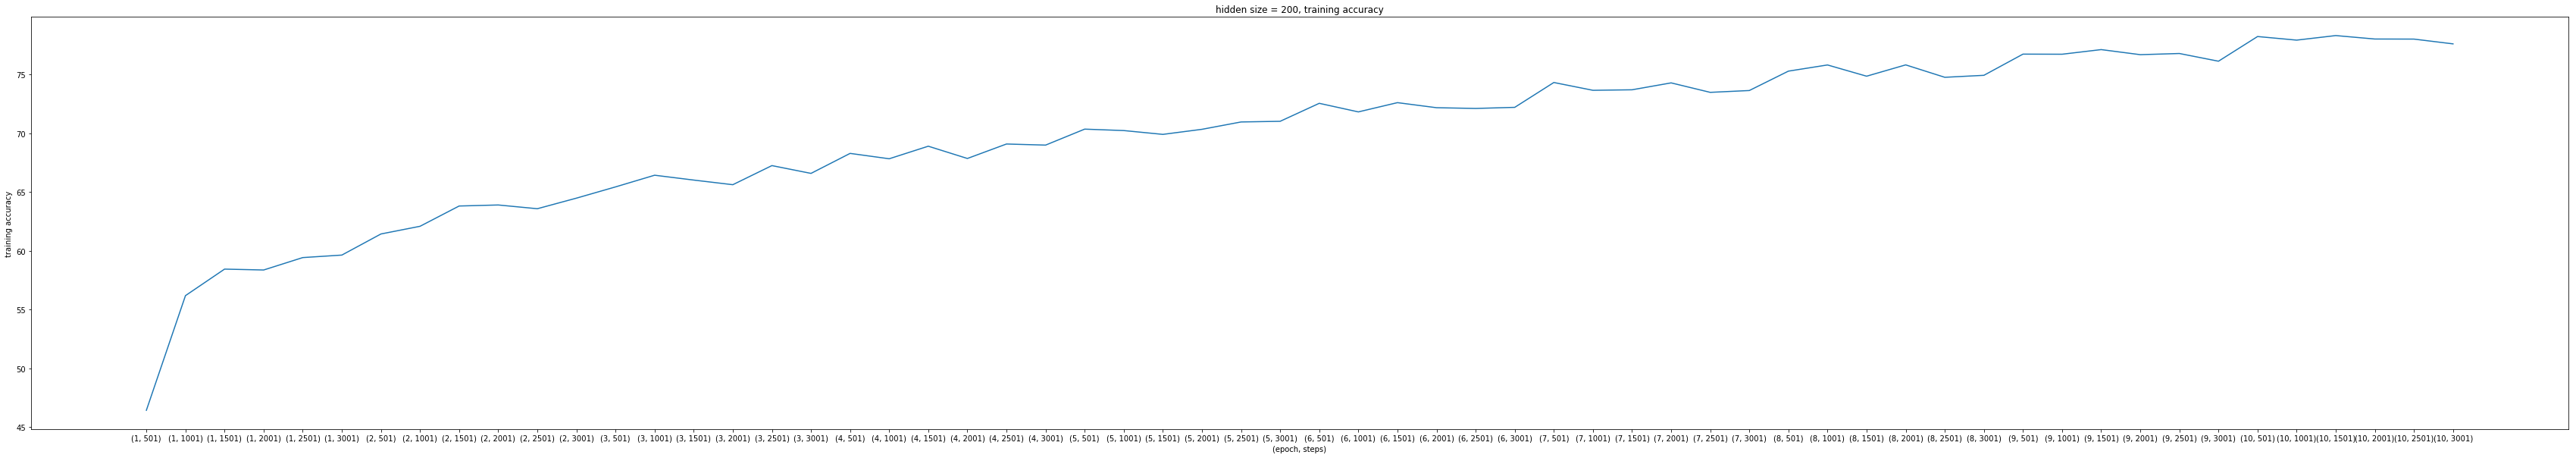

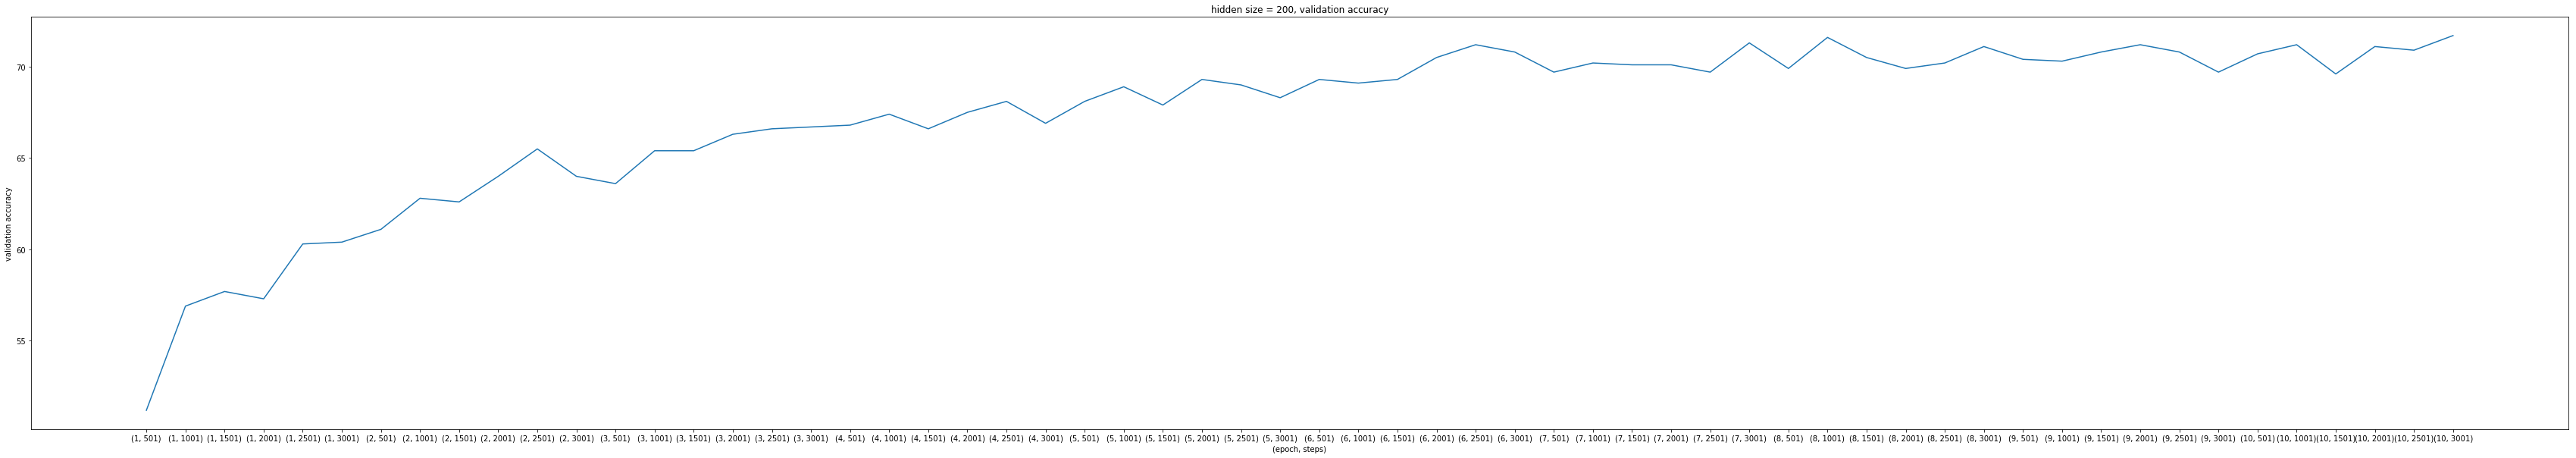

Epoch: [1/10], Step: [501/3125], trainning Acc: 47.44885229540918, Validation Acc: 51.2
Epoch: [1/10], Step: [1001/3125], trainning Acc: 55.3, Validation Acc: 55.1
Epoch: [1/10], Step: [1501/3125], trainning Acc: 57.14375, Validation Acc: 58.8
Epoch: [1/10], Step: [2001/3125], trainning Acc: 57.7375, Validation Acc: 58.0
Epoch: [1/10], Step: [2501/3125], trainning Acc: 60.26875, Validation Acc: 61.0
Epoch: [1/10], Step: [3001/3125], trainning Acc: 60.3625, Validation Acc: 59.8
Epoch: [2/10], Step: [501/3125], trainning Acc: 62.33782435129741, Validation Acc: 61.4
Epoch: [2/10], Step: [1001/3125], trainning Acc: 63.4625, Validation Acc: 62.5
Epoch: [2/10], Step: [1501/3125], trainning Acc: 62.95625, Validation Acc: 63.5
Epoch: [2/10], Step: [2001/3125], trainning Acc: 64.56875, Validation Acc: 64.6
Epoch: [2/10], Step: [2501/3125], trainning Acc: 64.3, Validation Acc: 65.4
Epoch: [2/10], Step: [3001/3125], trainning Acc: 64.625, Validation Acc: 65.1
Epoch: [3/10], Step: [501/3125], trai

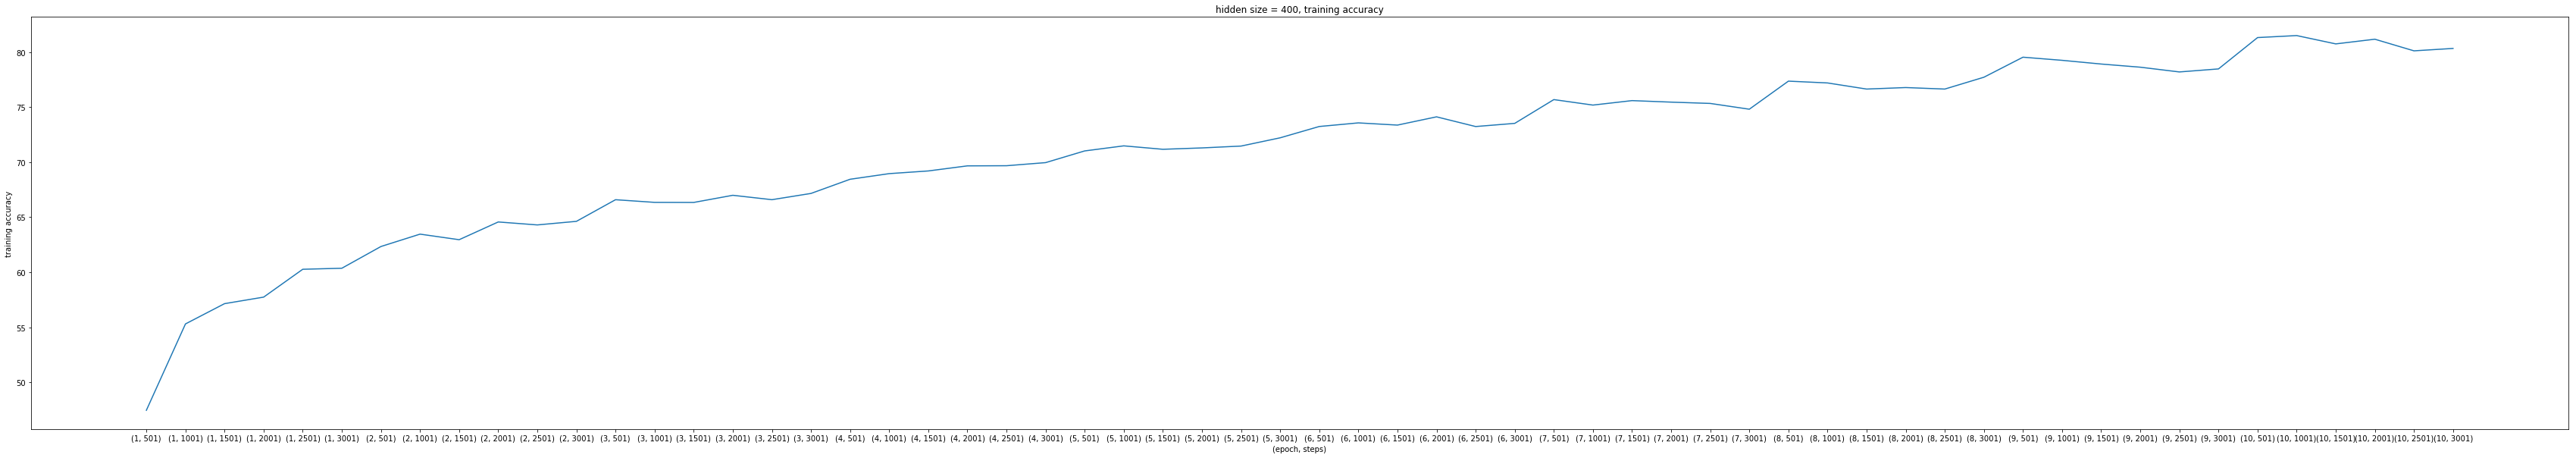

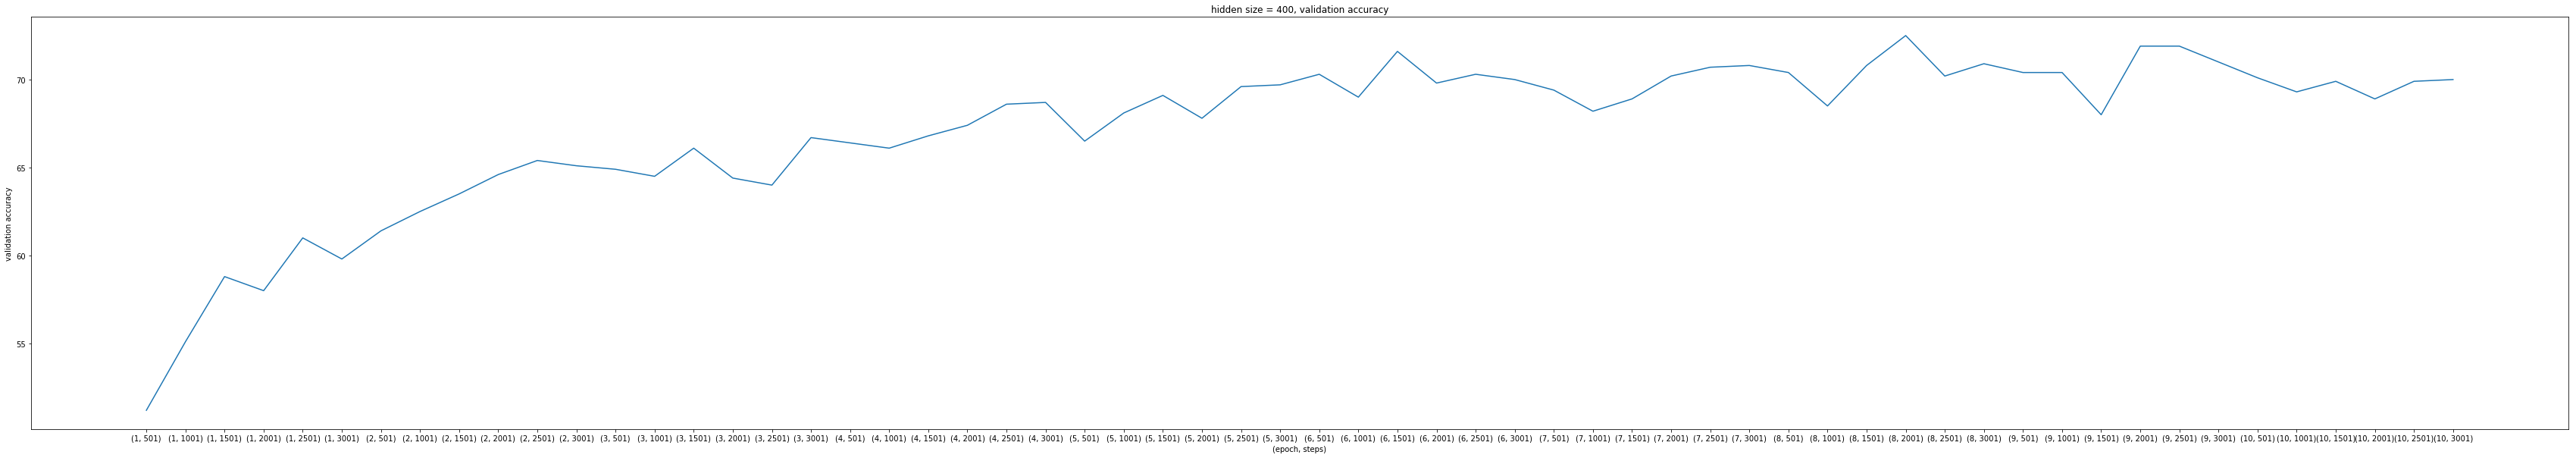

Epoch: [1/10], Step: [501/3125], trainning Acc: 47.10578842315369, Validation Acc: 50.7
Epoch: [1/10], Step: [1001/3125], trainning Acc: 54.8375, Validation Acc: 57.0
Epoch: [1/10], Step: [1501/3125], trainning Acc: 57.04375, Validation Acc: 57.1
Epoch: [1/10], Step: [2001/3125], trainning Acc: 58.39375, Validation Acc: 57.9
Epoch: [1/10], Step: [2501/3125], trainning Acc: 59.93125, Validation Acc: 59.8
Epoch: [1/10], Step: [3001/3125], trainning Acc: 61.40625, Validation Acc: 61.3
Epoch: [2/10], Step: [501/3125], trainning Acc: 62.70583832335329, Validation Acc: 62.8
Epoch: [2/10], Step: [1001/3125], trainning Acc: 63.4625, Validation Acc: 64.3
Epoch: [2/10], Step: [1501/3125], trainning Acc: 63.24375, Validation Acc: 65.2
Epoch: [2/10], Step: [2001/3125], trainning Acc: 64.40625, Validation Acc: 63.8
Epoch: [2/10], Step: [2501/3125], trainning Acc: 65.4125, Validation Acc: 64.9
Epoch: [2/10], Step: [3001/3125], trainning Acc: 65.01875, Validation Acc: 65.8
Epoch: [3/10], Step: [501/3

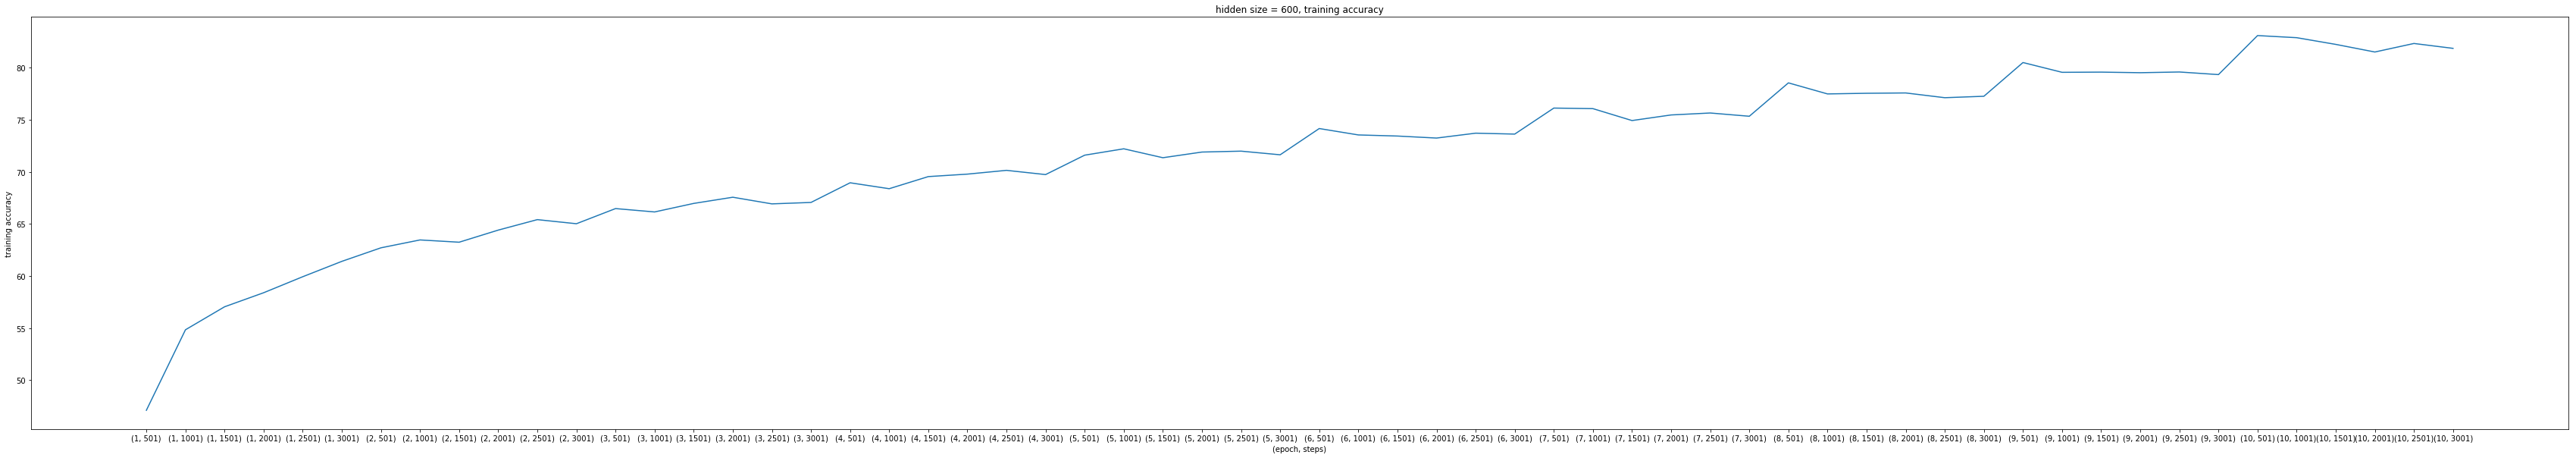

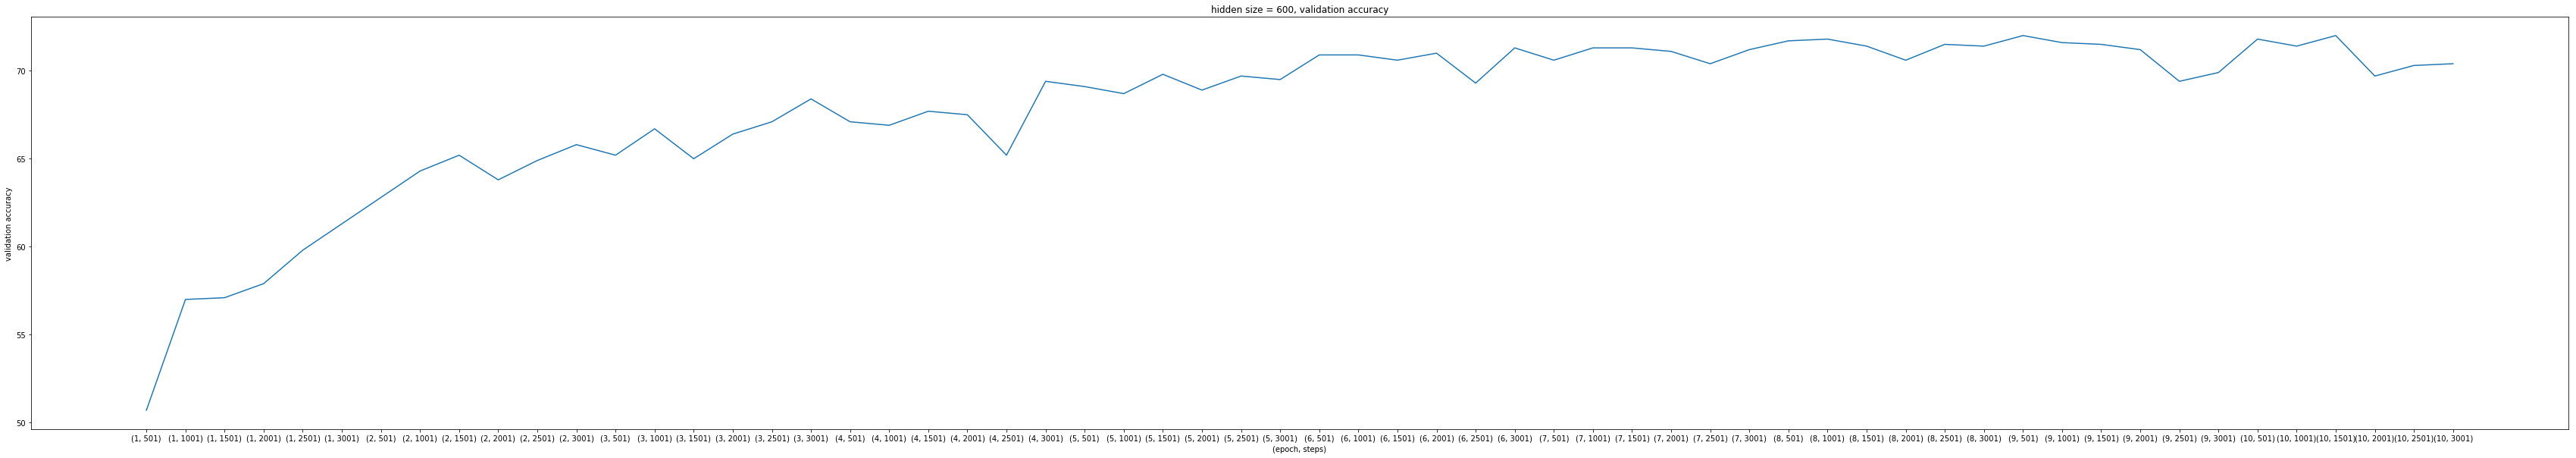

In [20]:
for hidden_size in [200,400, 600]:
    with open('output-gpu.txt', 'a') as f:
        f.write("RNN hidden size {} \n".format(hidden_size))
    max_val, train_acc, val_accuracy, epoch_list = run_model(hidden_size = hidden_size)
    
    #print ("Val Acc {}".format(max_val))
    
    with open('output-gpu.txt', 'a') as f:
        f.write("Val Acc {} \n".format(max_val))

    plt.figure(figsize=(60,10))
    plt.plot(range(len(epoch_list)), train_acc)
    plt.xticks(range(len(epoch_list)), epoch_list)
    plt.xlabel("(epoch, steps)")
    plt.ylabel("training accuracy")
    plt.title("hidden size = "+str( hidden_size)+ ", training accuracy")
    plt.savefig("train_accuracy-gpu,hidden"+str(hidden_size)+".png")
    plt.show()

    plt.figure(figsize=(60,10))
    plt.plot(range(len(epoch_list)), val_accuracy)
    plt.xticks(range(len(epoch_list)), epoch_list)
    plt.xlabel("(epoch, steps)")
    plt.ylabel("validation accuracy")
    plt.title("hidden size = "+str( hidden_size)+ ", validation accuracy")
    plt.savefig("val_acc,hidden-gpu"+str(hidden_size)+".png")
    plt.show()

#### tune interaction between 2 sentence

In [21]:
MULT = 1
class RNN_gru_interaction(nn.Module):
    def __init__(self, emb_size, hidden_size, num_classes, dic_size, embed):
        # RNN Accepts the following hyperparams:
        # emb_size: Embedding Size
        # hidden_size: Hidden Size of layer in RNN
        # num_layers: number of layers in RNN
        # num_classes: number of output classes
        # vocab_size: vocabulary size
        super(RNN_gru_interaction, self).__init__()

        self.hidden_size = hidden_size
        
        mask = np.zeros((embed.shape[0],1))
        mask[0] = 1
        mask[1] = 1
        mask = torch.from_numpy(mask).float()
        
        self.mask_embedding = nn.Embedding.from_pretrained(mask, freeze = True)
        self.dynamic_embedding = nn.Embedding.from_pretrained(embed, freeze = False)
        
        self.gru = nn.GRU(emb_size, hidden_size, 1, batch_first=True, bidirectional = True)
        self.linear1 = nn.Linear(hidden_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, num_classes)

    def init_hidden(self, batch_size):
        # Function initializes the activation of recurrent neural net at timestep 0
        # Needs to be in format (num_layers, batch_size, hidden_size)
        hidden = torch.randn(2, batch_size, self.hidden_size)

        return hidden

    def forward(self, x, lengths): 
        batch_size, seq_len = x[0].size()
        vec_representations = []
        for idx, data in enumerate(x):
            # sort
            _, sorted_idx = torch.sort(lengths[idx],descending=True)
            _, unsorted_idx = torch.sort(sorted_idx)
            
            #print(data)
            #print(sorted_idx)
            
            #embed = self.dynamic_embedding(data[sorted_idx]).float()+self.frozen_embedding(data[sorted_idx]).float()
            
            e = self.dynamic_embedding(data[sorted_idx]).float()
            #print(e)
            embed = self.mask_embedding(data[sorted_idx])*e+(1-self.mask_embedding(data[sorted_idx]))*e.clone().detach()

            self.hidden = self.init_hidden(batch_size).to(device)

            # pack padded sequence
            #print(lengths[idx][sorted_idx])
            embed = torch.nn.utils.rnn.pack_padded_sequence(embed, lengths[idx].cpu()[sorted_idx].numpy(), batch_first=True)
            
            # fprop though RNN
            rnn_out, self.hidden = self.gru(embed, self.hidden)
            # undo packing
            rnn_out, _ = torch.nn.utils.rnn.pad_packed_sequence(rnn_out, batch_first=True)
            
            # add to representation with original order
            #print(hidden)
            #hidden = torch.cat([self.hidden[0,:,:],self.hidden[1,:,:]], dim=1)
            hidden = torch.sum(self.hidden, dim = 0)
            #print(hidden.shape)
            
            vec_representations.append(hidden[unsorted_idx])
            
        
        # if MULT is true, element-wise 2 representation, otherwise concat
        if MULT:
            representations = vec_representations[0]*vec_representations[1]
        else:
            representations = torch.cat(vec_representations, 1)
        logits = self.linear1(representations)
        logits = F.relu(logits)
        logits = self.linear2(logits)
        return logits

In [151]:
def run_model(hidden_size=200, num_classes=3, dic_size=len(id2token), embed=torch.from_numpy(embedding_matrix)):
    learning_rate = 3e-4
    num_epochs = 10 # number epoch to train
    
    model = RNN_gru_interaction(emb_size=300, hidden_size=hidden_size, num_classes=num_classes, dic_size=dic_size, embed=embed)
    model.to(device)
    # Criterion and Optimizer
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    # Train the model
    total_step = len(snli_train_loader_rnn)
    val_accuracy = []
    #train_loss = []
    train_accuracy = []
    correct = 0
    total = 0
    epoch_list = []
    max_val = 0
    
    for epoch in range(num_epochs):
        #running_loss = 0
        correct = 0
        total = 0
        for i, (data1, data2, lengths1, lengths2, labels) in enumerate(snli_train_loader_rnn):
            data1 = data1.to(device)
            data2 = data2.to(device)
            lengths1 = lengths1.to(device)
            lengths2 = lengths2.to(device)
            labels = labels.to(device)
            
            model.train()
            optimizer.zero_grad()
            # Forward pass
            outputs = model([data1, data2], [lengths1, lengths2])
            #print(outputs)
            loss = criterion(outputs, labels)

            # Backward and optimize 1
            #emb = model.embedding.weight.clone().detach()
            loss.backward()
            optimizer.step()
            #model.embedding.weight.data = mask * model.embedding.weight + (1-mask) * emb
            #running_loss += loss.item()
            
            # calculate train accuracy
            predicted = (F.softmax(outputs, dim=1)).max(1, keepdim=True)[1]

            total += labels.size(0)
            correct += predicted.eq(labels.view_as(predicted)).sum().item()
            
            # validate every 100 iterations
            if i > 0 and i % 500 == 0:
                # validate
                val_acc = test_model(snli_val_loader_rnn, model)
                #train_loss.append(running_loss/500)
                train_accuracy.append(100 * correct / total)
                val_accuracy.append(val_acc)
                epoch_list.append(str((epoch+1, i+1)))
                
                if val_acc > max_val:
                    torch.save(model.state_dict(), "rnnbestmult.pt")
                    
                print('Epoch: [{}/{}], Step: [{}/{}], trainning Acc: {}, Validation Acc: {}'.format( 
                       epoch+1, num_epochs, i+1, len(snli_train_loader_rnn), 100 * correct / total,val_acc))
                
                with open('output-gpu.txt', 'a') as f:
                    f.write('Epoch: [{}/{}], Step: [{}/{}], trainning Acc: {}, Validation Acc: {} \n'.format( 
                       epoch+1, num_epochs, i+1, len(snli_train_loader_rnn), 100 * correct / total,val_acc))
                
                #running_loss = 0
                correct = 0
                total = 0
    
    val_acc_i = test_model(snli_val_loader_rnn, model)
    max_val = max(val_accuracy)
    
    if val_acc_i > max_val:
        torch.save(model.state_dict(), "rnnbestmult.pt")
    
    return max(max_val, val_acc_i), train_accuracy, val_accuracy, epoch_list


Epoch: [1/10], Step: [501/3125], trainning Acc: 40.225798403193615, Validation Acc: 42.4
Epoch: [1/10], Step: [1001/3125], trainning Acc: 47.9625, Validation Acc: 50.5
Epoch: [1/10], Step: [1501/3125], trainning Acc: 52.225, Validation Acc: 54.5
Epoch: [1/10], Step: [2001/3125], trainning Acc: 55.36875, Validation Acc: 56.1
Epoch: [1/10], Step: [2501/3125], trainning Acc: 56.43125, Validation Acc: 59.9
Epoch: [1/10], Step: [3001/3125], trainning Acc: 57.6, Validation Acc: 60.7
Epoch: [2/10], Step: [501/3125], trainning Acc: 59.76172654690619, Validation Acc: 59.3
Epoch: [2/10], Step: [1001/3125], trainning Acc: 60.5375, Validation Acc: 60.6
Epoch: [2/10], Step: [1501/3125], trainning Acc: 61.51875, Validation Acc: 61.5
Epoch: [2/10], Step: [2001/3125], trainning Acc: 61.83125, Validation Acc: 62.9
Epoch: [2/10], Step: [2501/3125], trainning Acc: 63.15625, Validation Acc: 64.0
Epoch: [2/10], Step: [3001/3125], trainning Acc: 63.5875, Validation Acc: 64.8
Epoch: [3/10], Step: [501/3125],

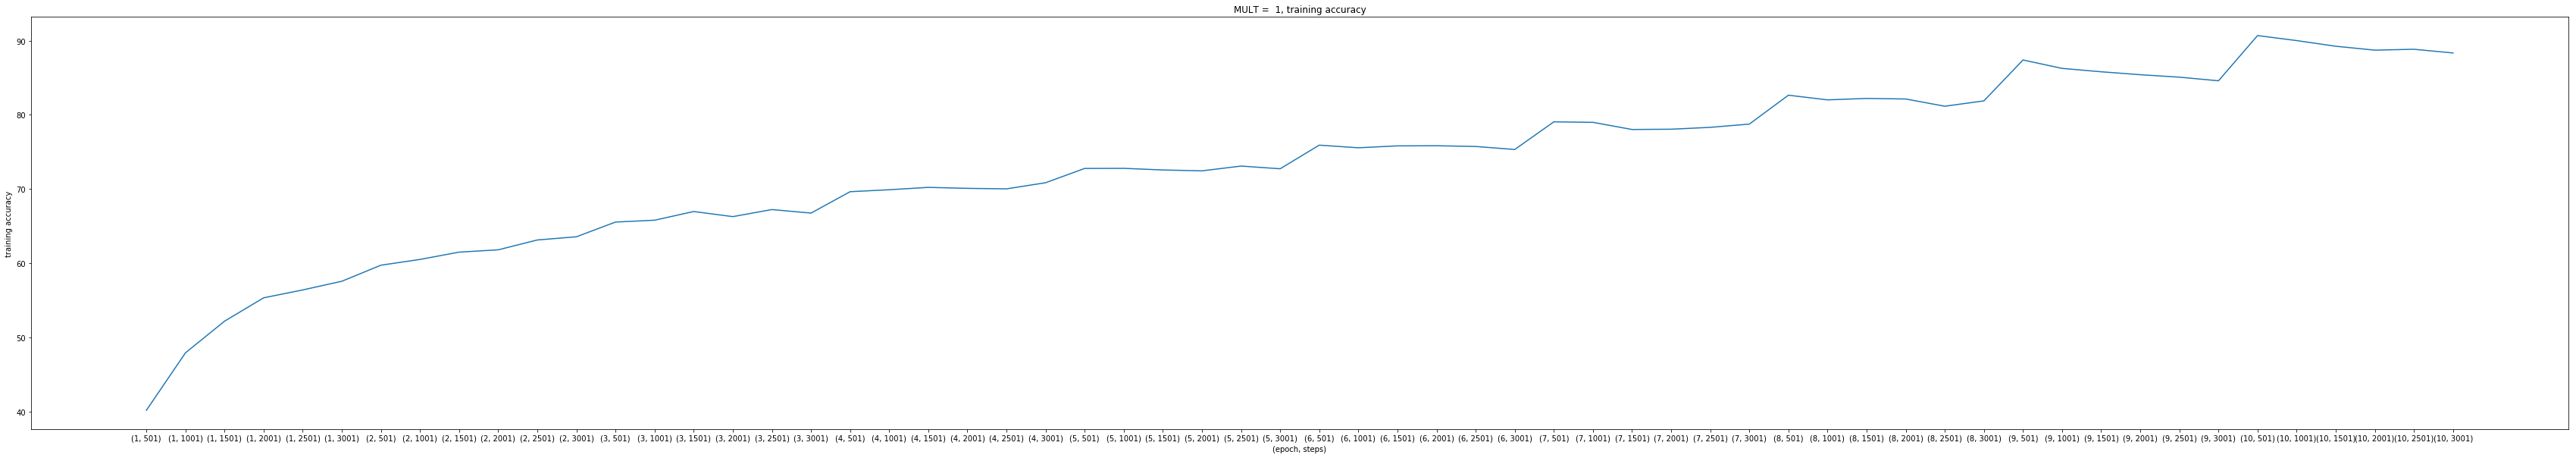

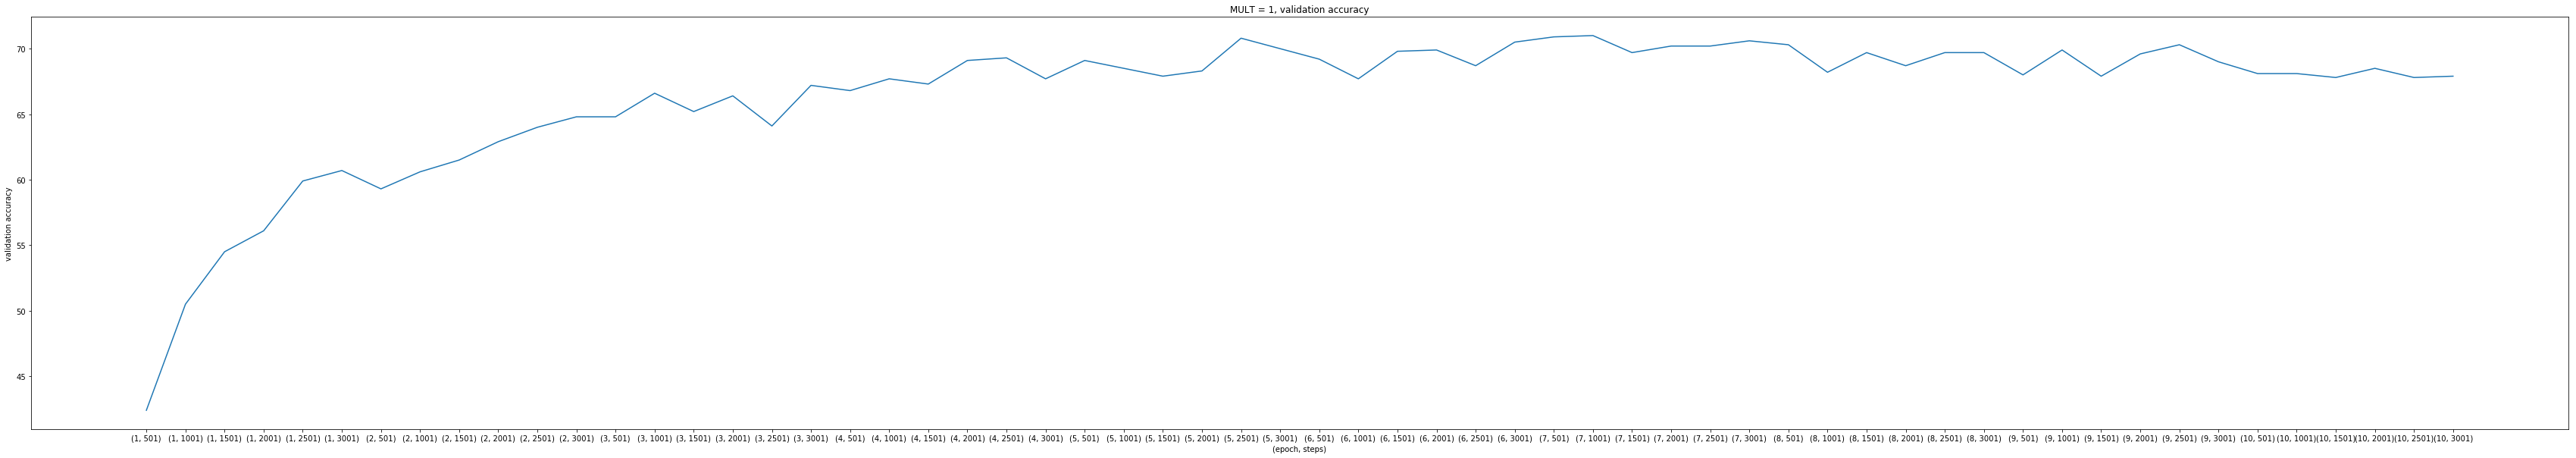

In [152]:
with open('output-gpu.txt', 'a') as f:
        f.write("RNN mult {} \n".format(MULT))
max_val, train_acc, val_accuracy, epoch_list = run_model(hidden_size=600)

#print ("Val Acc {}".format(max_val))

with open('output-gpu.txt', 'a') as f:
    f.write("Val Acc {} \n".format(max_val))

plt.figure(figsize=(60,10))
plt.plot(range(len(epoch_list)), train_acc)
plt.xticks(range(len(epoch_list)), epoch_list)
plt.xlabel("(epoch, steps)")
plt.ylabel("training accuracy")
plt.title("MULT =  "+str( MULT)+ ", training accuracy")
plt.savefig("train_accuracy-gpumult.png")
plt.show()

plt.figure(figsize=(60,10))
plt.plot(range(len(epoch_list)), val_accuracy)
plt.xticks(range(len(epoch_list)), epoch_list)
plt.xlabel("(epoch, steps)")
plt.ylabel("validation accuracy")
plt.title("MULT = "+str( MULT)+ ", validation accuracy")
plt.savefig("val_acc-gpumult.png")
plt.show()

## Test CNN & RNN best model on MNLI data set

In [24]:
import pandas as pd

In [25]:
mnli_val_data = pd.read_csv('mnli_val.tsv', sep='\t', header = 0)

In [29]:
cnn_best_model = CNN(emb_size=300, hidden_size=600, num_classes=3, dic_size=len(id2token), embed=torch.from_numpy(embedding_matrix), kernel_size=3, padding_size=1)
cnn_best_model.to(device)
cnn_best_model.load_state_dict(torch.load("cnnbesthidden600.pt"))
rnn_best_model = RNN_gru(emb_size=300, hidden_size=400, num_classes=3, dic_size=len(id2token), embed=torch.from_numpy(embedding_matrix))
rnn_best_model.to(device)
rnn_best_model.load_state_dict(torch.load("rnnbest400.pt"))
genre_type = list(mnli_val_data.genre.unique())

In [32]:
for genre_t in genre_type:
    sub_val_data = mnli_val_data[mnli_val_data.genre == genre_t]
    val_data_m = [list(item) for item in zip([sent.split() for sent in sub_val_data.sentence1], [sent.split() for sent in sub_val_data.sentence2])]
    val_label_m = [label_dic[i] for i in sub_val_data.label]
    mnli_val_dataset = SnliDataset(val_data_m, val_label_m,token2id)
    mnli_val_loader = torch.utils.data.DataLoader(dataset=mnli_val_dataset,
                                           batch_size=BATCH_SIZE,
                                           collate_fn=Snli_collate_func,
                                           shuffle=True)
    
    cnn_acc = test_model(mnli_val_loader, cnn_best_model)
    print("For genre {}, validation accuracy for best cnn model is {}".format(genre_t, cnn_acc))
    
    rnn_acc = test_model(mnli_val_loader, rnn_best_model)
    print("For genre {}, validation accuracy for best rnn model is {}".format(genre_t, rnn_acc))
    
    
    

For genre fiction, validation accuracy for best cnn model is 46.733668341708544
For genre fiction, validation accuracy for best rnn model is 51.85929648241206
For genre telephone, validation accuracy for best cnn model is 46.169154228855724
For genre telephone, validation accuracy for best rnn model is 51.64179104477612
For genre slate, validation accuracy for best cnn model is 43.812375249500995
For genre slate, validation accuracy for best rnn model is 46.30738522954092
For genre government, validation accuracy for best cnn model is 45.374015748031496
For genre government, validation accuracy for best rnn model is 49.11417322834646
For genre travel, validation accuracy for best cnn model is 46.13034623217923
For genre travel, validation accuracy for best rnn model is 48.574338085539715


### print 3 correct, 3 incorrect instance for SNLI validation data

In [ ]:
for data1, data2, lengths1, lengths2, labels in loader:
        data1 = data1.to(device)
        data2 = data2.to(device)
        lengths1 = lengths1.to(device)
        lengths2 = lengths2.to(device)
        labels = labels.to(device)
        
        data_batch, lengths_batch, label_batch = [data1, data2], [lengths1, lengths2], labels
        outputs = F.softmax(model(data_batch, lengths_batch), dim=1)
        predicted = outputs.max(1, keepdim=True)[1]
        #print(predicted)

        total += labels.size(0)
        correct += predicted.eq(labels.view_as(predicted)).sum().item()

In [148]:
# get correct and incorrect examples
correct_list = []
incorrect_list = []
c_lab = []
inc_lab = []
c_predicted =[]
inc_predicted = []

for idx, val_text in enumerate(val_data[:50]):
    val_i = SnliDataset([val_text], [val_label[:50][idx]],token2id)
    val_i_loader = torch.utils.data.DataLoader(dataset=val_i,
                                           batch_size=1,
                                           collate_fn=Snli_collate_func,
                                           shuffle=True)
    
    for data1, data2, lengths1, lengths2, labels in val_i_loader:
        data1 = data1.to(device)
        data2 = data2.to(device)
        lengths1 = lengths1.to(device)
        lengths2 = lengths2.to(device)
        labels = labels.to(device)
        
        data_batch, lengths_batch, label_batch = [data1, data2], [lengths1, lengths2], labels
        outputs = F.softmax(rnn_best_model(data_batch, lengths_batch), dim=1)
        predicted = outputs.max(1, keepdim=True)[1]
        
        if predicted.eq(labels.view_as(predicted)).sum().item():
            correct_list.append(val_data[idx])
            c_lab.append(labels.item())
            c_predicted.append(predicted.item())
        else:
            incorrect_list.append(val_data[idx])
            inc_lab.append(labels.item())
            inc_predicted.append(predicted.item())

In [149]:
# print correct
for i in range(5):
    sent = correct_list[i]
    print("sentence 1")
    print(' '.join(sent[0]))
    print("sentence 2")
    print(' '.join(sent[1]))
    print("true label")
    print(c_lab[i])
    print("predicted lable")
    print(c_predicted[i])
    print("\n")
    

sentence 1
Three women on a stage , one wearing red shoes , black pants , and a gray shirt is sitting on a prop , another is sitting on the floor , and the third wearing a black shirt and pants is standing , as a gentleman in the back tunes an instrument .
sentence 2
There are two women standing on the stage
true label
0
predicted lable
0


sentence 1
Four people sit on a subway two read books , one looks at a cellphone and is wearing knee high boots .
sentence 2
Multiple people are on a subway together , with each of them doing their own thing .
true label
1
predicted lable
1


sentence 1
bicycles stationed while a group of people socialize .
sentence 2
People get together near a stand of bicycles .
true label
1
predicted lable
1


sentence 1
Man in overalls with two horses .
sentence 2
a man in overalls with two horses
true label
1
predicted lable
1


sentence 1
Man observes a wavelength given off by an electronic device .
sentence 2
The man is examining what wavelength is given off 

In [150]:
# print incorrect
for i in range(5):
    sent = incorrect_list[i]
    print("sentence 1")
    print(' '.join(sent[0]))
    print("sentence 2")
    print(' '.join(sent[1]))
    print("true label")
    print(inc_lab[i])
    print("predicted lable")
    print(inc_predicted[i])
    print("\n")
    

sentence 1
Two people are in a green forest .
sentence 2
The forest is not dead .
true label
1
predicted lable
0


sentence 1
A large group of people stand outside on a road while people on a higher level look on at them .
sentence 2
One group of people are watching what another group does .
true label
1
predicted lable
2


sentence 1
Man in white shirt and blue jeans looking to the side while walking down a busy sidewalk .
sentence 2
Man has a blue shirt on .
true label
0
predicted lable
1


sentence 1
A group of people dressed in Santa Claus suits are looking towards an audience while a DJ runs a sound board and another person throws green balls into the air .
sentence 2
A band plays at a beach party .
true label
2
predicted lable
0


sentence 1
A red jeep hangs from the edge of a rocky cliff as a girl looks on .
sentence 2
The vehicle is red .
true label
1
predicted lable
0




In [100]:
a = np.array(val_data)[[i == 2 for i in val_label]]


In [118]:
len(a)

338